# Aegea Forecast R2

Neste notebook será analisado as métricas de Forecast que são preenchidos pela regional no cubo FRC.100 e repassados para o cubo GRL.010 onde se encontra o histórico. Com esses dados iremos análisar métrica a métrica Unidade a Unidade da regional 2 em busca de padrões de sazinalidade mudança de nível e tendência

## Ferramentas
Para isso iremos exportar os dados hisóricos abertos em unidade e métrica em um gráfico de linha, com uma previsão inicial usando o Prophet

### Importação dos dados

In [156]:
import pandas as pd
import numpy as np
import os

In [8]:
pd_inicio = pd.read_excel('./GRL.010.xlsx',header=4, engine="openpyxl")

D:\python\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [7]:
pd_inicio.head()

,GRL.D.Unidades,GRL.M.Dados_Base,Saldos Base,jan/14,fev/14,mar/14,abr/14,mai/14,jun/14,jul/14,...,2051F,2052F,2053F,2054F,2055F,2056F,2057F,2058F,2059F,2060F
0,Prolagos,Economias Cresc. Vegetativo - Água,0.0,160581.000000,975.000000,847.000000,63.000000,-119.000000,117.000000,1146.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Prolagos,Volume Médio por Economia - Água,0.0,14.750233,13.962550,14.592841,13.057497,12.768835,12.349088,12.414067,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Prolagos,Reequilíbrio (Direto Água),0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Prolagos,Tarifa Média m³ - Água,0.0,7.551333,7.420482,7.603003,7.155527,7.013754,6.823973,6.757294,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Prolagos,Reequilíbrio (Indireto Água),0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import os

In [46]:
import locale
locale.setlocale(locale.LC_ALL, 'pt_BR.utf8')


'pt_BR.utf8'

In [12]:
metricas = pd_inicio['GRL.M.Dados_Base'].unique()
unidades = pd_inicio['GRL.D.Unidades'].unique()

In [48]:
lista_tempo = []
for i in pd_inicio.columns[3:]:
    if(str(i)[-1]!='F'):
        lista_tempo.append(i)
pd.to_datetime(lista_tempo,format="%b/%y")

DatetimeIndex(['2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01',
               ...
               '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01',
               '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01',
               '2024-11-01', '2024-12-01'],
              dtype='datetime64[ns]', length=132, freq=None)

### Teste de uma métrica específica

In [219]:
pdEspec = pd_inicio[(pd_inicio['GRL.D.Unidades']==unidades[0]) & (pd_inicio['GRL.M.Dados_Base']==metricas[1]) ].drop(
            columns={'GRL.D.Unidades','GRL.M.Dados_Base','Saldos Base'}).T.reset_index()

In [220]:
pdTempo = pdEspec[pdEspec['index'].isin(lista_tempo)]

In [221]:
pdTempo['ds'] = pd.to_datetime(pdTempo['index'],format="%b/%y")

C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\32637153.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdTempo['ds'] = pd.to_datetime(pdTempo['index'],format="%b/%y")


In [222]:
pdTempo.columns

Index(['index', 1, 'ds'], dtype='object')

<Axes: xlabel='ds'>

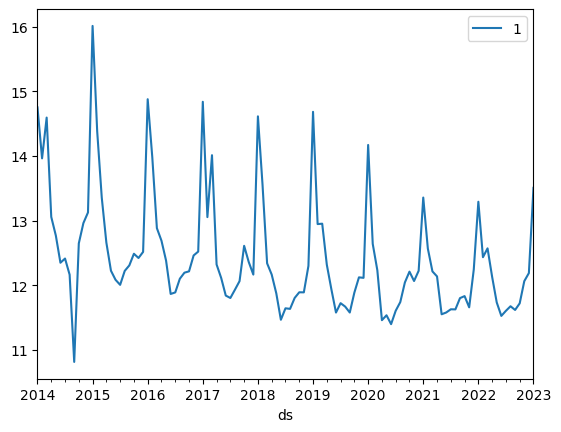

In [223]:
pdTempo[pdTempo['ds']<'2023-02-01'][['ds',1]].set_index('ds').plot()

### Prophet no específico
definindo teste a partir de 2022-02 e definindo 0 como NA

In [224]:
limite = '2022-02-01'
limitePrev = '2023-02-01'

In [225]:
pdTempo['y'] = pdTempo[1]

C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\3236098586.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdTempo['y'] = pdTempo[1]


In [226]:
pdTempo.head()

,index,1,ds,y
0,jan/14,14.750233,2014-01-01,14.750233
1,fev/14,13.962550,2014-02-01,13.962550
2,mar/14,14.592841,2014-03-01,14.592841
3,abr/14,13.057497,2014-04-01,13.057497
4,mai/14,12.768835,2014-05-01,12.768835


In [227]:
m = Prophet()

In [228]:
m.fit(pdTempo[pdTempo['ds']<limite])

12:32:45 - cmdstanpy - INFO - Chain [1] start processing
12:32:45 - cmdstanpy - INFO - Chain [1] done processing


In [229]:
future = pdTempo[(pdTempo['ds']>=limite)&(pdTempo['ds']<limitePrev)]
forecast = m.predict(future[['ds']])

In [230]:
mean_squared_error(forecast['yhat'],future[['y']])

0.12775179137792725

In [231]:
lprevisao = [ str(j)+'-'+str(i) for i in range(2023,2025) for j in range(1,13) if((~(j<=1) & (i==2023))|((i==2024)&(j<3)) ) ]
previsao = pd.DataFrame({'ds':pd.to_datetime(lprevisao)})

In [232]:
previsao

,ds
0,2023-02-01
1,2023-03-01
2,2023-04-01
3,2023-05-01
4,2023-06-01
5,2023-07-01
6,2023-08-01
7,2023-09-01
8,2023-10-01
9,2023-11-01


In [233]:
m2 = Prophet()
m2.fit(pdTempo[pdTempo['ds']<limitePrev])

12:32:48 - cmdstanpy - INFO - Chain [1] start processing
12:32:48 - cmdstanpy - INFO - Chain [1] done processing


In [234]:
pdTempo[pdTempo['ds']<'2023-03-01'].tail()

,index,1,ds,y
108,out/22,11.721386,2022-10-01,11.721386
109,nov/22,12.064646,2022-11-01,12.064646
110,dez/22,12.189596,2022-12-01,12.189596
112,jan/23,13.507046,2023-01-01,13.507046
113,fev/23,12.858807,2023-02-01,12.858807


In [235]:
dfPrev = m2.predict(previsao)
dfPrev.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-02-01,11.992882,12.369183,13.224977,11.992860,11.992910,0.799584,0.799584,0.799584,0.799584,0.799584,0.799584,0.0,0.0,0.0,12.792466
1,2023-03-01,11.989307,12.079383,12.896325,11.989071,11.989607,0.505761,0.505761,0.505761,0.505761,0.505761,0.505761,0.0,0.0,0.0,12.495068
2,2023-04-01,11.985349,11.407471,12.245006,11.984741,11.985991,-0.160549,-0.160549,-0.160549,-0.160549,-0.160549,-0.160549,0.0,0.0,0.0,11.824800
3,2023-05-01,11.981519,11.027989,11.917650,11.980421,11.982697,-0.504292,-0.504292,-0.504292,-0.504292,-0.504292,-0.504292,0.0,0.0,0.0,11.477228
4,2023-06-01,11.977561,10.888410,11.729737,11.975875,11.979399,-0.669198,-0.669198,-0.669198,-0.669198,-0.669198,-0.669198,0.0,0.0,0.0,11.308363


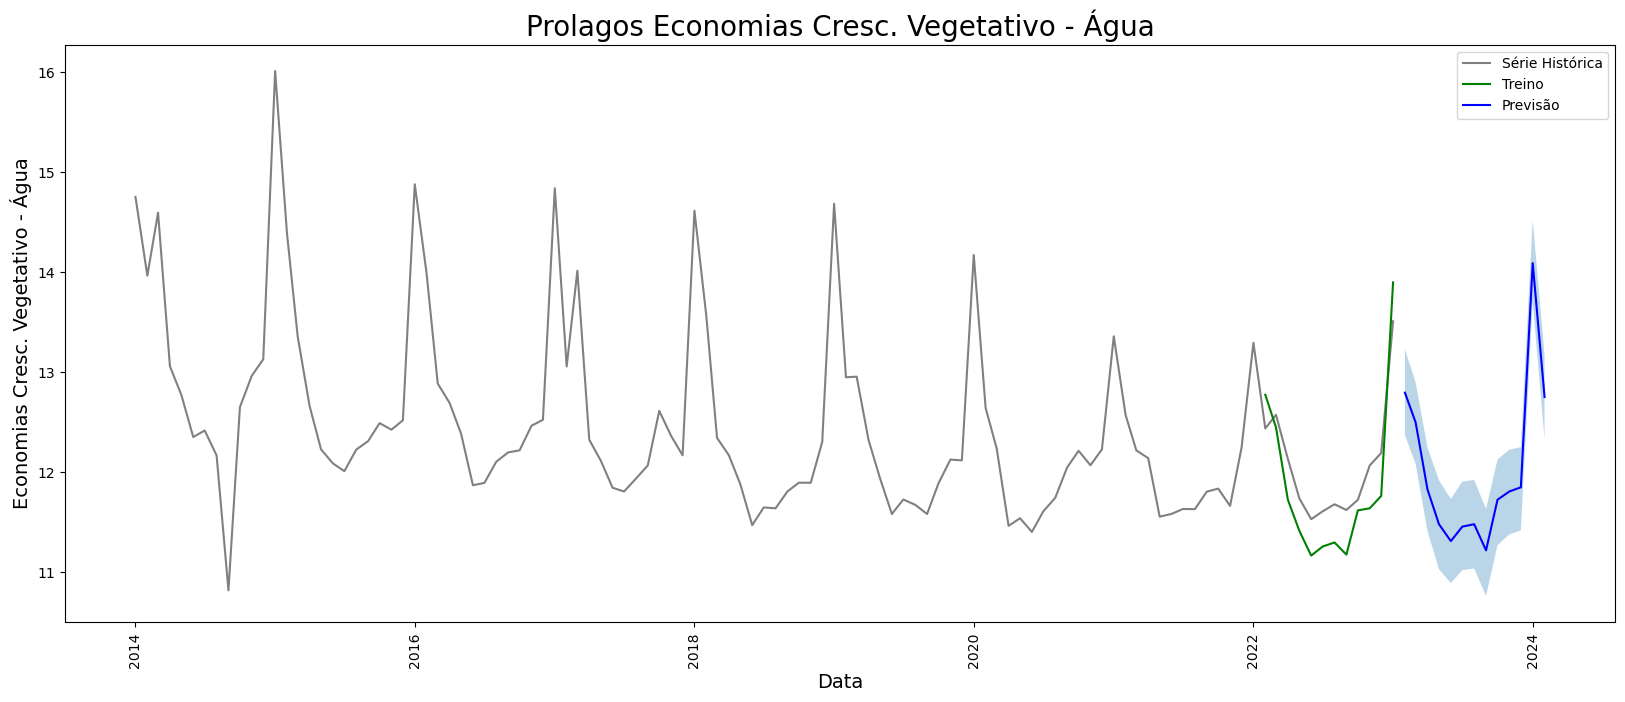

In [236]:
pdTempo2 = pdTempo[pdTempo['ds']<limitePrev]
fig = plt.figure(figsize=[20, 7.5]); # Set dimensions for figure
plt.plot(pdTempo2['ds'], pdTempo2['y'],'gray')
plt.plot(forecast['ds'], forecast['yhat'],'green')
plt.plot(dfPrev['ds'], dfPrev['yhat'],'blue')
plt.fill_between(dfPrev['ds'],dfPrev['yhat_lower'],dfPrev['yhat_upper'],alpha=0.3)
plt.title('{} {}'.format(unidades[0],metricas[0]),size=20)
plt.ylabel('{}'.format(metricas[0]),size=14)
plt.xlabel('Data',size=14)
plt.xticks(rotation=90,size=10)
plt.grid(False)
plt.legend(['Série Histórica','Treino','Previsão'])
plt.show()
#plt.savefig(path+'_{}_{}_{}_{}_'.format(
#            linha['ALL.D.IBGE'],linha['ALL.D.Produto_Destino'],linha['ALL.D.Tipo_Cliente'],j)+
#          '{:f}.jpeg'.format(MSE)
#         )
plt.close(fig)

### Análise em Massa

In [179]:
metricas[5].replace('/','_')

'Receita Indireta - Água'

In [237]:
for metrica in metricas:
#for metrica in metricas[21:]:
    print('Metrica ',metrica)
    for unidade in unidades:
        pd_Espec = pd_inicio[(pd_inicio['GRL.D.Unidades']==unidade) & (pd_inicio['GRL.M.Dados_Base']==metrica) ].drop(
            columns={'GRL.D.Unidades','GRL.M.Dados_Base','Saldos Base'}).T.reset_index()
        metricap = metrica.replace('/','_')
        unidadep = unidade.replace('/','_')
        print('Unidade ',unidadep,' - Metrica ',metricap)
        path = './TS_R2/{}/'.format(metricap)
        if not os.path.exists(path):
            os.makedirs(path)
        pd_Espec.columns = ['index','valor']
        pd_Espec.replace(0, np.nan, inplace = True)
        pd_Tempo = pd_Espec[pd_Espec['index'].isin(lista_tempo)]
        pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
        #print(pd_Tempo.head())
        pd_Tempo['y'] = pd_Tempo['valor']
        mf = Prophet()
        try:
            mf.fit(pd_Tempo[pd_Tempo['ds']<limite])
            future = pd_Tempo[(pd_Tempo['ds']>=limite)&(pd_Tempo['ds']<limitePrev)]
            forecast = mf.predict(future[['ds']])
        except:
            forecast = pd.DataFrame({'ds':[],'yhat':[]})
        mp = Prophet()
        try:
            mp.fit(pd_Tempo[pd_Tempo['ds']<limitePrev])
            dfPrev = mp.predict(previsao)
        except:
            dfPrev = pd.DataFrame({'ds':[],'yhat':[],'yhat_lower':[],'yhat_upper':[]})
        pdTempo2 = pd_Tempo[pd_Tempo['ds']<limitePrev]
        fig = plt.figure(figsize=[20, 7.5]); # Set dimensions for figure
        plt.plot(pdTempo2['ds'], pdTempo2['y'],'gray')
        plt.plot(forecast['ds'], forecast['yhat'],'green')
        plt.plot(dfPrev['ds'], dfPrev['yhat'],'blue')
        plt.fill_between(dfPrev['ds'],dfPrev['yhat_lower'],dfPrev['yhat_upper'],alpha=0.3)
        plt.title('{} {}'.format(unidade,metrica),size=20)
        plt.ylabel('{}'.format(metrica),size=14)
        plt.xlabel('Data',size=14)
        plt.xticks(rotation=90,size=10)
        plt.grid(False)
        plt.legend(['Série Histórica','Treino','Previsão'])
        #plt.show()
        plt.savefig(path+'{}_{}'.format(
                    unidadep,metricap)+
                  '.jpeg'
                 )
        plt.close(fig)

Metrica  Economias Cresc. Vegetativo - Água
Unidade  Prolagos  - Metrica  Economias Cresc. Vegetativo - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:33:06 - cmdstanpy - INFO - Chain [1] start processing
12:33:07 - cmdstanpy - INFO - Chain [1] done processing
12:33:07 - cmdstanpy - INFO - Chain [1] start processing
12:33:07

Unidade  Ambiental Metrosul  - Metrica  Economias Cresc. Vegetativo - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Economias Cresc. Vegetativo - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Economias Cresc. Vegetativo - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Economias Cresc. Vegetativo - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Economias Cresc. Vegetativo - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Vila Velha Ambiental  - Metrica  Economias Cresc. Vegetativo - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas do Mirante  - Metrica  Economias Cresc. Vegetativo - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Economias Cresc. Vegetativo - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:33:13 - cmdstanpy - INFO - Chain [1] start processing
12:33:14 - cmdstanpy - INFO - Chain [1] done processing
12:33:14 - cmdstanpy - INFO - Chain [1] start processing
12:33:14

Unidade  Águas de Holambra  - Metrica  Economias Cresc. Vegetativo - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:33:15 - cmdstanpy - INFO - Chain [1] start processing
12:33:15 - cmdstanpy - INFO - Chain [1] done processing
12:33:16 - cmdstanpy - INFO - Chain [1] start processing
12:33:16

Unidade  Águas de São Francisco do Sul  - Metrica  Economias Cresc. Vegetativo - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:33:17 - cmdstanpy - INFO - Chain [1] start processing
12:33:18 - cmdstanpy - INFO - Chain [1] done processing
12:33:18 - cmdstanpy - INFO - Chain [1] start processing
12:33:19

Unidade  Águas de Camboriú  - Metrica  Economias Cresc. Vegetativo - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:33:19 - cmdstanpy - INFO - Chain [1] start processing
12:33:20 - cmdstanpy - INFO - Chain [1] done processing
12:33:21 - cmdstanpy - INFO - Chain [1] start processing
12:33:21

Unidade  Águas de Penha  - Metrica  Economias Cresc. Vegetativo - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:33:22 - cmdstanpy - INFO - Chain [1] start processing
12:33:23 - cmdstanpy - INFO - Chain [1] done processing
12:33:23 - cmdstanpy - INFO - Chain [1] start processing
12:33:24

Unidade  Águas de Bombinhas  - Metrica  Economias Cresc. Vegetativo - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:33:24 - cmdstanpy - INFO - Chain [1] start processing
12:33:25 - cmdstanpy - INFO - Chain [1] done processing
12:33:25 - cmdstanpy - INFO - Chain [1] start processing
12:33:26

Metrica  Volume Médio por Economia - Água
Unidade  Prolagos  - Metrica  Volume Médio por Economia - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:33:27 - cmdstanpy - INFO - Chain [1] start processing
12:33:27 - cmdstanpy - INFO - Chain [1] done processing
12:33:28 - cmdstanpy - INFO - Chain [1] start processing
12:33:28

Unidade  Ambiental Metrosul  - Metrica  Volume Médio por Economia - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Volume Médio por Economia - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Volume Médio por Economia - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Volume Médio por Economia - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Volume Médio por Economia - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Vila Velha Ambiental  - Metrica  Volume Médio por Economia - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas do Mirante  - Metrica  Volume Médio por Economia - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Volume Médio por Economia - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:33:33 - cmdstanpy - INFO - Chain [1] start processing
12:33:34 - cmdstanpy - INFO - Chain [1] done processing
12:33:35 - cmdstanpy - INFO - Chain [1] start processing
12:33:35

Unidade  Águas de Holambra  - Metrica  Volume Médio por Economia - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:33:35 - cmdstanpy - INFO - Chain [1] start processing
12:33:36 - cmdstanpy - INFO - Chain [1] done processing
12:33:36 - cmdstanpy - INFO - Chain [1] start processing
12:33:37

Unidade  Águas de São Francisco do Sul  - Metrica  Volume Médio por Economia - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:33:38 - cmdstanpy - INFO - Chain [1] start processing
12:33:39 - cmdstanpy - INFO - Chain [1] done processing
12:33:39 - cmdstanpy - INFO - Chain [1] start processing
12:33:39

Unidade  Águas de Camboriú  - Metrica  Volume Médio por Economia - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:33:40 - cmdstanpy - INFO - Chain [1] start processing
12:33:41 - cmdstanpy - INFO - Chain [1] done processing
12:33:41 - cmdstanpy - INFO - Chain [1] start processing
12:33:42

Unidade  Águas de Penha  - Metrica  Volume Médio por Economia - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:33:43 - cmdstanpy - INFO - Chain [1] start processing
12:33:43 - cmdstanpy - INFO - Chain [1] done processing
12:33:44 - cmdstanpy - INFO - Chain [1] start processing
12:33:45

Unidade  Águas de Bombinhas  - Metrica  Volume Médio por Economia - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:33:45 - cmdstanpy - INFO - Chain [1] start processing
12:33:46 - cmdstanpy - INFO - Chain [1] done processing
12:33:46 - cmdstanpy - INFO - Chain [1] start processing
12:33:47

Metrica  Reequilíbrio (Direto Água)
Unidade  Prolagos  - Metrica  Reequilíbrio (Direto Água)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Metrosul  - Metrica  Reequilíbrio (Direto Água)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Reequilíbrio (Direto Água)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Reequilíbrio (Direto Água)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Reequilíbrio (Direto Água)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Reequilíbrio (Direto Água)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Vila Velha Ambiental  - Metrica  Reequilíbrio (Direto Água)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas do Mirante  - Metrica  Reequilíbrio (Direto Água)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Reequilíbrio (Direto Água)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Holambra  - Metrica  Reequilíbrio (Direto Água)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de São Francisco do Sul  - Metrica  Reequilíbrio (Direto Água)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Camboriú  - Metrica  Reequilíbrio (Direto Água)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Penha  - Metrica  Reequilíbrio (Direto Água)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Bombinhas  - Metrica  Reequilíbrio (Direto Água)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Metrica  Tarifa Média m³ - Água
Unidade  Prolagos  - Metrica  Tarifa Média m³ - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:33:57 - cmdstanpy - INFO - Chain [1] start processing
12:33:58 - cmdstanpy - INFO - Chain [1] done processing
12:33:58 - cmdstanpy - INFO - Chain [1] start processing
12:33:58

Unidade  Ambiental Metrosul  - Metrica  Tarifa Média m³ - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Tarifa Média m³ - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Tarifa Média m³ - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Tarifa Média m³ - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Tarifa Média m³ - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Vila Velha Ambiental  - Metrica  Tarifa Média m³ - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas do Mirante  - Metrica  Tarifa Média m³ - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Tarifa Média m³ - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:34:04 - cmdstanpy - INFO - Chain [1] start processing
12:34:05 - cmdstanpy - INFO - Chain [1] done processing
12:34:05 - cmdstanpy - INFO - Chain [1] start processing
12:34:05

Unidade  Águas de Holambra  - Metrica  Tarifa Média m³ - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:34:06 - cmdstanpy - INFO - Chain [1] start processing
12:34:06 - cmdstanpy - INFO - Chain [1] done processing
12:34:07 - cmdstanpy - INFO - Chain [1] start processing
12:34:08

Unidade  Águas de São Francisco do Sul  - Metrica  Tarifa Média m³ - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:34:08 - cmdstanpy - INFO - Chain [1] start processing
12:34:09 - cmdstanpy - INFO - Chain [1] done processing
12:34:09 - cmdstanpy - INFO - Chain [1] start processing
12:34:11

Unidade  Águas de Camboriú  - Metrica  Tarifa Média m³ - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:34:11 - cmdstanpy - INFO - Chain [1] start processing
12:34:12 - cmdstanpy - INFO - Chain [1] done processing
12:34:12 - cmdstanpy - INFO - Chain [1] start processing
12:34:13

Unidade  Águas de Penha  - Metrica  Tarifa Média m³ - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:34:14 - cmdstanpy - INFO - Chain [1] start processing
12:34:15 - cmdstanpy - INFO - Chain [1] done processing
12:34:15 - cmdstanpy - INFO - Chain [1] start processing
12:34:16

Unidade  Águas de Bombinhas  - Metrica  Tarifa Média m³ - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:34:17 - cmdstanpy - INFO - Chain [1] start processing
12:34:18 - cmdstanpy - INFO - Chain [1] done processing
12:34:18 - cmdstanpy - INFO - Chain [1] start processing
12:34:19

Metrica  Reequilíbrio (Indireto Água)
Unidade  Prolagos  - Metrica  Reequilíbrio (Indireto Água)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Metrosul  - Metrica  Reequilíbrio (Indireto Água)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Reequilíbrio (Indireto Água)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Reequilíbrio (Indireto Água)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Reequilíbrio (Indireto Água)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Reequilíbrio (Indireto Água)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Vila Velha Ambiental  - Metrica  Reequilíbrio (Indireto Água)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas do Mirante  - Metrica  Reequilíbrio (Indireto Água)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Reequilíbrio (Indireto Água)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Holambra  - Metrica  Reequilíbrio (Indireto Água)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de São Francisco do Sul  - Metrica  Reequilíbrio (Indireto Água)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Camboriú  - Metrica  Reequilíbrio (Indireto Água)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Penha  - Metrica  Reequilíbrio (Indireto Água)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Bombinhas  - Metrica  Reequilíbrio (Indireto Água)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Metrica  Receita Indireta - Água
Unidade  Prolagos  - Metrica  Receita Indireta - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:34:30 - cmdstanpy - INFO - Chain [1] start processing
12:34:31 - cmdstanpy - INFO - Chain [1] done processing
12:34:31 - cmdstanpy - INFO - Chain [1] start processing
12:34:31

Unidade  Ambiental Metrosul  - Metrica  Receita Indireta - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Receita Indireta - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Receita Indireta - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Receita Indireta - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Receita Indireta - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Vila Velha Ambiental  - Metrica  Receita Indireta - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas do Mirante  - Metrica  Receita Indireta - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Receita Indireta - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:34:37 - cmdstanpy - INFO - Chain [1] start processing
12:34:37 - cmdstanpy - INFO - Chain [1] done processing
12:34:37 - cmdstanpy - INFO - Chain [1] start processing
12:34:38

Unidade  Águas de Holambra  - Metrica  Receita Indireta - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:34:38 - cmdstanpy - INFO - Chain [1] start processing
12:34:39 - cmdstanpy - INFO - Chain [1] done processing
12:34:39 - cmdstanpy - INFO - Chain [1] start processing
12:34:40

Unidade  Águas de São Francisco do Sul  - Metrica  Receita Indireta - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:34:40 - cmdstanpy - INFO - Chain [1] start processing
12:34:41 - cmdstanpy - INFO - Chain [1] done processing
12:34:41 - cmdstanpy - INFO - Chain [1] start processing
12:34:42

Unidade  Águas de Camboriú  - Metrica  Receita Indireta - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:34:43 - cmdstanpy - INFO - Chain [1] start processing
12:34:43 - cmdstanpy - INFO - Chain [1] done processing
12:34:44 - cmdstanpy - INFO - Chain [1] start processing
12:34:44

Unidade  Águas de Penha  - Metrica  Receita Indireta - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:34:45 - cmdstanpy - INFO - Chain [1] start processing
12:34:46 - cmdstanpy - INFO - Chain [1] done processing
12:34:46 - cmdstanpy - INFO - Chain [1] start processing
12:34:47

Unidade  Águas de Bombinhas  - Metrica  Receita Indireta - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:34:47 - cmdstanpy - INFO - Chain [1] start processing
12:34:48 - cmdstanpy - INFO - Chain [1] done processing
12:34:48 - cmdstanpy - INFO - Chain [1] start processing
12:34:49

Metrica  Cut off - Direto água
Unidade  Prolagos  - Metrica  Cut off - Direto água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:34:49 - cmdstanpy - INFO - Chain [1] start processing
12:34:50 - cmdstanpy - INFO - Chain [1] done processing
12:34:50 - cmdstanpy - INFO - Chain [1] start processing
12:34:51

Unidade  Ambiental Metrosul  - Metrica  Cut off - Direto água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Cut off - Direto água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Cut off - Direto água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Cut off - Direto água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Cut off - Direto água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Vila Velha Ambiental  - Metrica  Cut off - Direto água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas do Mirante  - Metrica  Cut off - Direto água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Cut off - Direto água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:34:56 - cmdstanpy - INFO - Chain [1] start processing
12:34:57 - cmdstanpy - INFO - Chain [1] done processing
12:34:57 - cmdstanpy - INFO - Chain [1] start processing
12:34:58

Unidade  Águas de Holambra  - Metrica  Cut off - Direto água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:34:59 - cmdstanpy - INFO - Chain [1] start processing
12:34:59 - cmdstanpy - INFO - Chain [1] done processing
12:35:00 - cmdstanpy - INFO - Chain [1] start processing
12:35:00

Unidade  Águas de São Francisco do Sul  - Metrica  Cut off - Direto água


12:35:01 - cmdstanpy - INFO - Chain [1] start processing
12:35:02 - cmdstanpy - INFO - Chain [1] done processing
12:35:02 - cmdstanpy - INFO - Chain [1] start processing
12:35:03 - cmdstanpy - INFO - Chain [1] done processing


Unidade  Águas de Camboriú  - Metrica  Cut off - Direto água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:35:04 - cmdstanpy - INFO - Chain [1] start processing
12:35:04 - cmdstanpy - INFO - Chain [1] done processing
12:35:05 - cmdstanpy - INFO - Chain [1] start processing
12:35:05

Unidade  Águas de Penha  - Metrica  Cut off - Direto água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:35:06 - cmdstanpy - INFO - Chain [1] start processing
12:35:07 - cmdstanpy - INFO - Chain [1] done processing
12:35:07 - cmdstanpy - INFO - Chain [1] start processing
12:35:08

Unidade  Águas de Bombinhas  - Metrica  Cut off - Direto água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:35:09 - cmdstanpy - INFO - Chain [1] start processing
12:35:09 - cmdstanpy - INFO - Chain [1] done processing
12:35:10 - cmdstanpy - INFO - Chain [1] start processing
12:35:10

Metrica  Economias Cresc. Vegetativo - Esgoto
Unidade  Prolagos  - Metrica  Economias Cresc. Vegetativo - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Metrosul  - Metrica  Economias Cresc. Vegetativo - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:35:12 - cmdstanpy - INFO - Chain [1] start processing
12:35:12 - cmdstanpy - INFO - Chain [1] done processing
12:35:12 - cmdstanpy - INFO - Chain [1] start processing
12:35:13

Unidade  Águas de Meriti  - Metrica  Economias Cresc. Vegetativo - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Economias Cresc. Vegetativo - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Economias Cresc. Vegetativo - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:35:15 - cmdstanpy - INFO - Chain [1] start processing
12:35:15 - cmdstanpy - INFO - Chain [1] done processing
12:35:15 - cmdstanpy - INFO - Chain [1] start processing
12:35:15

Unidade  Serra Ambiental  - Metrica  Economias Cresc. Vegetativo - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:35:16 - cmdstanpy - INFO - Chain [1] start processing
12:35:17 - cmdstanpy - INFO - Chain [1] done processing
12:35:17 - cmdstanpy - INFO - Chain [1] start processing
12:35:18

Unidade  Vila Velha Ambiental  - Metrica  Economias Cresc. Vegetativo - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:35:18 - cmdstanpy - INFO - Chain [1] start processing
12:35:19 - cmdstanpy - INFO - Chain [1] done processing
12:35:19 - cmdstanpy - INFO - Chain [1] start processing
12:35:20

Unidade  Águas do Mirante  - Metrica  Economias Cresc. Vegetativo - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:35:20 - cmdstanpy - INFO - Chain [1] start processing
12:35:21 - cmdstanpy - INFO - Chain [1] done processing
12:35:21 - cmdstanpy - INFO - Chain [1] start processing
12:35:22

Unidade  Águas de Matão  - Metrica  Economias Cresc. Vegetativo - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:35:22 - cmdstanpy - INFO - Chain [1] start processing
12:35:23 - cmdstanpy - INFO - Chain [1] done processing
12:35:23 - cmdstanpy - INFO - Chain [1] start processing
12:35:24

Unidade  Águas de Holambra  - Metrica  Economias Cresc. Vegetativo - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:35:24 - cmdstanpy - INFO - Chain [1] start processing
12:35:25 - cmdstanpy - INFO - Chain [1] done processing
12:35:25 - cmdstanpy - INFO - Chain [1] start processing
12:35:26

Unidade  Águas de São Francisco do Sul  - Metrica  Economias Cresc. Vegetativo - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:35:27 - cmdstanpy - INFO - Chain [1] start processing
12:35:39 - cmdstanpy - INFO - Chain [1] done processing
12:35:40 - cmdstanpy - INFO - Chain [1] start processing
12:35:40

Unidade  Águas de Camboriú  - Metrica  Economias Cresc. Vegetativo - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Penha  - Metrica  Economias Cresc. Vegetativo - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Bombinhas  - Metrica  Economias Cresc. Vegetativo - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:35:42 - cmdstanpy - INFO - Chain [1] start processing
12:35:43 - cmdstanpy - INFO - Chain [1] done processing
12:35:43 - cmdstanpy - INFO - Chain [1] start processing
12:35:44

Metrica  Volume Médio por Economia - Esgoto
Unidade  Prolagos  - Metrica  Volume Médio por Economia - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Metrosul  - Metrica  Volume Médio por Economia - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:35:45 - cmdstanpy - INFO - Chain [1] start processing
12:35:45 - cmdstanpy - INFO - Chain [1] done processing
12:35:46 - cmdstanpy - INFO - Chain [1] start processing
12:35:46

Unidade  Águas de Meriti  - Metrica  Volume Médio por Economia - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Volume Médio por Economia - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Volume Médio por Economia - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:35:48 - cmdstanpy - INFO - Chain [1] start processing
12:35:48 - cmdstanpy - INFO - Chain [1] done processing
12:35:49 - cmdstanpy - INFO - Chain [1] start processing
12:35:49

Unidade  Serra Ambiental  - Metrica  Volume Médio por Economia - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:35:50 - cmdstanpy - INFO - Chain [1] start processing
12:35:50 - cmdstanpy - INFO - Chain [1] done processing
12:35:50 - cmdstanpy - INFO - Chain [1] start processing
12:35:51

Unidade  Vila Velha Ambiental  - Metrica  Volume Médio por Economia - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:35:52 - cmdstanpy - INFO - Chain [1] start processing
12:35:52 - cmdstanpy - INFO - Chain [1] done processing
12:35:53 - cmdstanpy - INFO - Chain [1] start processing
12:35:53

Unidade  Águas do Mirante  - Metrica  Volume Médio por Economia - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:35:54 - cmdstanpy - INFO - Chain [1] start processing
12:35:55 - cmdstanpy - INFO - Chain [1] done processing
12:35:55 - cmdstanpy - INFO - Chain [1] start processing
12:35:55

Unidade  Águas de Matão  - Metrica  Volume Médio por Economia - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:35:56 - cmdstanpy - INFO - Chain [1] start processing
12:35:57 - cmdstanpy - INFO - Chain [1] done processing
12:35:57 - cmdstanpy - INFO - Chain [1] start processing
12:35:58

Unidade  Águas de Holambra  - Metrica  Volume Médio por Economia - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:35:58 - cmdstanpy - INFO - Chain [1] start processing
12:35:59 - cmdstanpy - INFO - Chain [1] done processing
12:35:59 - cmdstanpy - INFO - Chain [1] start processing
12:36:00

Unidade  Águas de São Francisco do Sul  - Metrica  Volume Médio por Economia - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:36:01 - cmdstanpy - INFO - Chain [1] start processing
12:36:01 - cmdstanpy - INFO - Chain [1] done processing
12:36:02 - cmdstanpy - INFO - Chain [1] start processing
12:36:02

Unidade  Águas de Camboriú  - Metrica  Volume Médio por Economia - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Penha  - Metrica  Volume Médio por Economia - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Bombinhas  - Metrica  Volume Médio por Economia - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:36:04 - cmdstanpy - INFO - Chain [1] start processing
12:36:05 - cmdstanpy - INFO - Chain [1] done processing
12:36:05 - cmdstanpy - INFO - Chain [1] start processing
12:36:06

Metrica  Reequilíbrio (Direto Esgoto)
Unidade  Prolagos  - Metrica  Reequilíbrio (Direto Esgoto)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Metrosul  - Metrica  Reequilíbrio (Direto Esgoto)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Reequilíbrio (Direto Esgoto)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Reequilíbrio (Direto Esgoto)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Reequilíbrio (Direto Esgoto)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Reequilíbrio (Direto Esgoto)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Vila Velha Ambiental  - Metrica  Reequilíbrio (Direto Esgoto)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas do Mirante  - Metrica  Reequilíbrio (Direto Esgoto)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Reequilíbrio (Direto Esgoto)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Holambra  - Metrica  Reequilíbrio (Direto Esgoto)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de São Francisco do Sul  - Metrica  Reequilíbrio (Direto Esgoto)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Camboriú  - Metrica  Reequilíbrio (Direto Esgoto)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Penha  - Metrica  Reequilíbrio (Direto Esgoto)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Bombinhas  - Metrica  Reequilíbrio (Direto Esgoto)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Metrica  Tarifa Média m³ - Esgoto
Unidade  Prolagos  - Metrica  Tarifa Média m³ - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Metrosul  - Metrica  Tarifa Média m³ - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:36:16 - cmdstanpy - INFO - Chain [1] start processing
12:36:17 - cmdstanpy - INFO - Chain [1] done processing
12:36:17 - cmdstanpy - INFO - Chain [1] start processing
12:36:17

Unidade  Águas de Meriti  - Metrica  Tarifa Média m³ - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Tarifa Média m³ - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Tarifa Média m³ - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:36:19 - cmdstanpy - INFO - Chain [1] start processing
12:36:19 - cmdstanpy - INFO - Chain [1] done processing
12:36:20 - cmdstanpy - INFO - Chain [1] start processing
12:36:20

Unidade  Serra Ambiental  - Metrica  Tarifa Média m³ - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:36:21 - cmdstanpy - INFO - Chain [1] start processing
12:36:21 - cmdstanpy - INFO - Chain [1] done processing
12:36:21 - cmdstanpy - INFO - Chain [1] start processing
12:36:22

Unidade  Vila Velha Ambiental  - Metrica  Tarifa Média m³ - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:36:23 - cmdstanpy - INFO - Chain [1] start processing
12:36:24 - cmdstanpy - INFO - Chain [1] done processing
12:36:24 - cmdstanpy - INFO - Chain [1] start processing
12:36:25

Unidade  Águas do Mirante  - Metrica  Tarifa Média m³ - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:36:25 - cmdstanpy - INFO - Chain [1] start processing
12:36:26 - cmdstanpy - INFO - Chain [1] done processing
12:36:26 - cmdstanpy - INFO - Chain [1] start processing
12:36:27

Unidade  Águas de Matão  - Metrica  Tarifa Média m³ - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:36:27 - cmdstanpy - INFO - Chain [1] start processing
12:36:28 - cmdstanpy - INFO - Chain [1] done processing
12:36:28 - cmdstanpy - INFO - Chain [1] start processing
12:36:28

Unidade  Águas de Holambra  - Metrica  Tarifa Média m³ - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:36:29 - cmdstanpy - INFO - Chain [1] start processing
12:36:30 - cmdstanpy - INFO - Chain [1] done processing
12:36:30 - cmdstanpy - INFO - Chain [1] start processing
12:36:31

Unidade  Águas de São Francisco do Sul  - Metrica  Tarifa Média m³ - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:36:32 - cmdstanpy - INFO - Chain [1] start processing
12:36:32 - cmdstanpy - INFO - Chain [1] done processing
12:36:32 - cmdstanpy - INFO - Chain [1] start processing
12:36:52

Unidade  Águas de Camboriú  - Metrica  Tarifa Média m³ - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Penha  - Metrica  Tarifa Média m³ - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Bombinhas  - Metrica  Tarifa Média m³ - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:36:54 - cmdstanpy - INFO - Chain [1] start processing
12:36:55 - cmdstanpy - INFO - Chain [1] done processing
12:36:55 - cmdstanpy - INFO - Chain [1] start processing
12:36:56

Metrica  Reequilíbrio (Indireto Esgoto)
Unidade  Prolagos  - Metrica  Reequilíbrio (Indireto Esgoto)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Metrosul  - Metrica  Reequilíbrio (Indireto Esgoto)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Reequilíbrio (Indireto Esgoto)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Reequilíbrio (Indireto Esgoto)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Reequilíbrio (Indireto Esgoto)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Reequilíbrio (Indireto Esgoto)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Vila Velha Ambiental  - Metrica  Reequilíbrio (Indireto Esgoto)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas do Mirante  - Metrica  Reequilíbrio (Indireto Esgoto)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Reequilíbrio (Indireto Esgoto)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Holambra  - Metrica  Reequilíbrio (Indireto Esgoto)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de São Francisco do Sul  - Metrica  Reequilíbrio (Indireto Esgoto)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Camboriú  - Metrica  Reequilíbrio (Indireto Esgoto)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Penha  - Metrica  Reequilíbrio (Indireto Esgoto)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Bombinhas  - Metrica  Reequilíbrio (Indireto Esgoto)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Metrica  Receita Indireta - Esgoto
Unidade  Prolagos  - Metrica  Receita Indireta - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:37:06 - cmdstanpy - INFO - Chain [1] start processing
12:37:06 - cmdstanpy - INFO - Chain [1] done processing
12:37:06 - cmdstanpy - INFO - Chain [1] start processing
12:37:07

Unidade  Ambiental Metrosul  - Metrica  Receita Indireta - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:37:07 - cmdstanpy - INFO - Chain [1] start processing
12:37:08 - cmdstanpy - INFO - Chain [1] done processing
12:37:08 - cmdstanpy - INFO - Chain [1] start processing
12:37:08

Unidade  Águas de Meriti  - Metrica  Receita Indireta - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Receita Indireta - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Receita Indireta - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Receita Indireta - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:37:11 - cmdstanpy - INFO - Chain [1] start processing
12:37:11 - cmdstanpy - INFO - Chain [1] done processing
12:37:11 - cmdstanpy - INFO - Chain [1] start processing
12:37:12

Unidade  Vila Velha Ambiental  - Metrica  Receita Indireta - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:37:13 - cmdstanpy - INFO - Chain [1] start processing
12:37:14 - cmdstanpy - INFO - Chain [1] done processing
12:37:14 - cmdstanpy - INFO - Chain [1] start processing
12:37:14

Unidade  Águas do Mirante  - Metrica  Receita Indireta - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:37:15 - cmdstanpy - INFO - Chain [1] start processing
12:37:15 - cmdstanpy - INFO - Chain [1] done processing
12:37:16 - cmdstanpy - INFO - Chain [1] start processing
12:37:16

Unidade  Águas de Matão  - Metrica  Receita Indireta - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:37:17 - cmdstanpy - INFO - Chain [1] start processing
12:37:18 - cmdstanpy - INFO - Chain [1] done processing
12:37:18 - cmdstanpy - INFO - Chain [1] start processing
12:37:19

Unidade  Águas de Holambra  - Metrica  Receita Indireta - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:37:20 - cmdstanpy - INFO - Chain [1] start processing
12:37:20 - cmdstanpy - INFO - Chain [1] done processing
12:37:21 - cmdstanpy - INFO - Chain [1] start processing
12:37:21

Unidade  Águas de São Francisco do Sul  - Metrica  Receita Indireta - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:37:22 - cmdstanpy - INFO - Chain [1] start processing
12:37:22 - cmdstanpy - INFO - Chain [1] done processing
12:37:22 - cmdstanpy - INFO - Chain [1] start processing
12:37:23

Unidade  Águas de Camboriú  - Metrica  Receita Indireta - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Penha  - Metrica  Receita Indireta - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Bombinhas  - Metrica  Receita Indireta - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:37:25 - cmdstanpy - INFO - Chain [1] start processing
12:37:25 - cmdstanpy - INFO - Chain [1] done processing
12:37:25 - cmdstanpy - INFO - Chain [1] start processing
12:37:26

Metrica  Cut off - Direto esgoto
Unidade  Prolagos  - Metrica  Cut off - Direto esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:37:26 - cmdstanpy - INFO - Chain [1] start processing
12:37:26 - cmdstanpy - INFO - Chain [1] done processing
12:37:27 - cmdstanpy - INFO - Chain [1] start processing
12:37:27

Unidade  Ambiental Metrosul  - Metrica  Cut off - Direto esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Cut off - Direto esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Cut off - Direto esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Cut off - Direto esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:37:29 - cmdstanpy - INFO - Chain [1] start processing
12:37:30 - cmdstanpy - INFO - Chain [1] done processing
12:37:30 - cmdstanpy - INFO - Chain [1] start processing
12:37:30

Unidade  Serra Ambiental  - Metrica  Cut off - Direto esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:37:31 - cmdstanpy - INFO - Chain [1] start processing
12:37:31 - cmdstanpy - INFO - Chain [1] done processing
12:37:32 - cmdstanpy - INFO - Chain [1] start processing
12:37:32

Unidade  Vila Velha Ambiental  - Metrica  Cut off - Direto esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:37:33 - cmdstanpy - INFO - Chain [1] start processing
12:37:33 - cmdstanpy - INFO - Chain [1] done processing
12:37:34 - cmdstanpy - INFO - Chain [1] start processing
12:37:34

Unidade  Águas do Mirante  - Metrica  Cut off - Direto esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Cut off - Direto esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:37:36 - cmdstanpy - INFO - Chain [1] start processing
12:37:36 - cmdstanpy - INFO - Chain [1] done processing
12:37:36 - cmdstanpy - INFO - Chain [1] start processing
12:37:37

Unidade  Águas de Holambra  - Metrica  Cut off - Direto esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:37:37 - cmdstanpy - INFO - Chain [1] start processing
12:37:38 - cmdstanpy - INFO - Chain [1] done processing
12:37:38 - cmdstanpy - INFO - Chain [1] start processing
12:37:39

Unidade  Águas de São Francisco do Sul  - Metrica  Cut off - Direto esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:37:39 - cmdstanpy - INFO - Chain [1] start processing
12:37:40 - cmdstanpy - INFO - Chain [1] done processing
12:37:40 - cmdstanpy - INFO - Chain [1] start processing
12:37:40

Unidade  Águas de Camboriú  - Metrica  Cut off - Direto esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Penha  - Metrica  Cut off - Direto esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Bombinhas  - Metrica  Cut off - Direto esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:37:42 - cmdstanpy - INFO - Chain [1] start processing
12:37:43 - cmdstanpy - INFO - Chain [1] done processing
12:37:43 - cmdstanpy - INFO - Chain [1] start processing
12:37:44

Metrica  Número de funcionários - Opex
Unidade  Prolagos  - Metrica  Número de funcionários - Opex


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:37:44 - cmdstanpy - INFO - Chain [1] start processing
12:37:45 - cmdstanpy - INFO - Chain [1] done processing
12:37:45 - cmdstanpy - INFO - Chain [1] start processing
12:37:45

Unidade  Ambiental Metrosul  - Metrica  Número de funcionários - Opex


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:37:46 - cmdstanpy - INFO - Chain [1] start processing
12:37:46 - cmdstanpy - INFO - Chain [1] done processing
12:37:46 - cmdstanpy - INFO - Chain [1] start processing
12:37:47

Unidade  Águas de Meriti  - Metrica  Número de funcionários - Opex


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:37:47 - cmdstanpy - INFO - Chain [1] start processing
12:37:48 - cmdstanpy - INFO - Chain [1] done processing
12:37:48 - cmdstanpy - INFO - Chain [1] start processing
12:37:49

Unidade  Gabinete - R2  - Metrica  Número de funcionários - Opex


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Número de funcionários - Opex


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:37:50 - cmdstanpy - INFO - Chain [1] start processing
12:37:50 - cmdstanpy - INFO - Chain [1] done processing
12:37:50 - cmdstanpy - INFO - Chain [1] start processing
12:37:51

Unidade  Serra Ambiental  - Metrica  Número de funcionários - Opex


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:37:51 - cmdstanpy - INFO - Chain [1] start processing
12:37:52 - cmdstanpy - INFO - Chain [1] done processing
12:37:52 - cmdstanpy - INFO - Chain [1] start processing
12:37:53

Unidade  Vila Velha Ambiental  - Metrica  Número de funcionários - Opex


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:37:54 - cmdstanpy - INFO - Chain [1] start processing
12:37:55 - cmdstanpy - INFO - Chain [1] done processing
12:37:55 - cmdstanpy - INFO - Chain [1] start processing
12:37:55

Unidade  Águas do Mirante  - Metrica  Número de funcionários - Opex


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:37:56 - cmdstanpy - INFO - Chain [1] start processing
12:37:57 - cmdstanpy - INFO - Chain [1] done processing
12:37:57 - cmdstanpy - INFO - Chain [1] start processing
12:37:58

Unidade  Águas de Matão  - Metrica  Número de funcionários - Opex


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:37:58 - cmdstanpy - INFO - Chain [1] start processing
12:37:59 - cmdstanpy - INFO - Chain [1] done processing
12:37:59 - cmdstanpy - INFO - Chain [1] start processing
12:37:59

Unidade  Águas de Holambra  - Metrica  Número de funcionários - Opex


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:38:00 - cmdstanpy - INFO - Chain [1] start processing
12:38:01 - cmdstanpy - INFO - Chain [1] done processing
12:38:01 - cmdstanpy - INFO - Chain [1] start processing
12:38:02

Unidade  Águas de São Francisco do Sul  - Metrica  Número de funcionários - Opex


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:38:03 - cmdstanpy - INFO - Chain [1] start processing
12:38:04 - cmdstanpy - INFO - Chain [1] done processing
12:38:04 - cmdstanpy - INFO - Chain [1] start processing
12:38:05

Unidade  Águas de Camboriú  - Metrica  Número de funcionários - Opex


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:38:06 - cmdstanpy - INFO - Chain [1] start processing
12:38:07 - cmdstanpy - INFO - Chain [1] done processing
12:38:07 - cmdstanpy - INFO - Chain [1] start processing
12:38:08

Unidade  Águas de Penha  - Metrica  Número de funcionários - Opex


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:38:08 - cmdstanpy - INFO - Chain [1] start processing
12:38:09 - cmdstanpy - INFO - Chain [1] done processing
12:38:10 - cmdstanpy - INFO - Chain [1] start processing
12:38:11

Unidade  Águas de Bombinhas  - Metrica  Número de funcionários - Opex


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:38:11 - cmdstanpy - INFO - Chain [1] start processing
12:38:12 - cmdstanpy - INFO - Chain [1] done processing
12:38:12 - cmdstanpy - INFO - Chain [1] start processing
12:38:13

Metrica  Provisão PLR
Unidade  Prolagos  - Metrica  Provisão PLR


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:38:14 - cmdstanpy - INFO - Chain [1] start processing
12:38:15 - cmdstanpy - INFO - Chain [1] done processing
12:38:15 - cmdstanpy - INFO - Chain [1] start processing
12:38:15

Unidade  Ambiental Metrosul  - Metrica  Provisão PLR


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:38:16 - cmdstanpy - INFO - Chain [1] start processing
12:38:16 - cmdstanpy - INFO - Chain [1] done processing
12:38:16 - cmdstanpy - INFO - Chain [1] start processing
12:38:17

Unidade  Águas de Meriti  - Metrica  Provisão PLR


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:38:17 - cmdstanpy - INFO - Chain [1] start processing
12:38:18 - cmdstanpy - INFO - Chain [1] done processing
12:38:18 - cmdstanpy - INFO - Chain [1] start processing
12:38:19

Unidade  Gabinete - R2  - Metrica  Provisão PLR


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Provisão PLR


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:38:20 - cmdstanpy - INFO - Chain [1] start processing
12:38:20 - cmdstanpy - INFO - Chain [1] done processing
12:38:20 - cmdstanpy - INFO - Chain [1] start processing
12:38:21

Unidade  Serra Ambiental  - Metrica  Provisão PLR


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:38:21 - cmdstanpy - INFO - Chain [1] start processing
12:38:22 - cmdstanpy - INFO - Chain [1] done processing
12:38:22 - cmdstanpy - INFO - Chain [1] start processing
12:38:22

Unidade  Vila Velha Ambiental  - Metrica  Provisão PLR


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:38:23 - cmdstanpy - INFO - Chain [1] start processing
12:38:24 - cmdstanpy - INFO - Chain [1] done processing
12:38:24 - cmdstanpy - INFO - Chain [1] start processing
12:38:24

Unidade  Águas do Mirante  - Metrica  Provisão PLR


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:38:25 - cmdstanpy - INFO - Chain [1] start processing
12:38:26 - cmdstanpy - INFO - Chain [1] done processing
12:38:26 - cmdstanpy - INFO - Chain [1] start processing
12:38:26

Unidade  Águas de Matão  - Metrica  Provisão PLR


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:38:27 - cmdstanpy - INFO - Chain [1] start processing
12:38:27 - cmdstanpy - INFO - Chain [1] done processing
12:38:28 - cmdstanpy - INFO - Chain [1] start processing
12:38:28

Unidade  Águas de Holambra  - Metrica  Provisão PLR


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:38:29 - cmdstanpy - INFO - Chain [1] start processing
12:38:29 - cmdstanpy - INFO - Chain [1] done processing
12:38:29 - cmdstanpy - INFO - Chain [1] start processing
12:38:30

Unidade  Águas de São Francisco do Sul  - Metrica  Provisão PLR


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:38:31 - cmdstanpy - INFO - Chain [1] start processing
12:38:31 - cmdstanpy - INFO - Chain [1] done processing
12:38:31 - cmdstanpy - INFO - Chain [1] start processing
12:38:32

Unidade  Águas de Camboriú  - Metrica  Provisão PLR


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:38:33 - cmdstanpy - INFO - Chain [1] start processing
12:38:33 - cmdstanpy - INFO - Chain [1] done processing
12:38:34 - cmdstanpy - INFO - Chain [1] start processing
12:38:34

Unidade  Águas de Penha  - Metrica  Provisão PLR


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:38:35 - cmdstanpy - INFO - Chain [1] start processing
12:38:36 - cmdstanpy - INFO - Chain [1] done processing
12:38:36 - cmdstanpy - INFO - Chain [1] start processing
12:38:37

Unidade  Águas de Bombinhas  - Metrica  Provisão PLR


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:38:37 - cmdstanpy - INFO - Chain [1] start processing
12:38:38 - cmdstanpy - INFO - Chain [1] done processing
12:38:38 - cmdstanpy - INFO - Chain [1] start processing
12:38:39

Metrica  Provisão 13o
Unidade  Prolagos  - Metrica  Provisão 13o


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:38:39 - cmdstanpy - INFO - Chain [1] start processing
12:38:40 - cmdstanpy - INFO - Chain [1] done processing
12:38:40 - cmdstanpy - INFO - Chain [1] start processing
12:38:41

Unidade  Ambiental Metrosul  - Metrica  Provisão 13o


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:38:41 - cmdstanpy - INFO - Chain [1] start processing
12:38:41 - cmdstanpy - INFO - Chain [1] done processing
12:38:42 - cmdstanpy - INFO - Chain [1] start processing
12:38:42

Unidade  Águas de Meriti  - Metrica  Provisão 13o


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:38:43 - cmdstanpy - INFO - Chain [1] start processing
12:38:43 - cmdstanpy - INFO - Chain [1] done processing
12:38:44 - cmdstanpy - INFO - Chain [1] start processing
12:38:44

Unidade  Gabinete - R2  - Metrica  Provisão 13o


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Provisão 13o


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:38:46 - cmdstanpy - INFO - Chain [1] start processing
12:38:46 - cmdstanpy - INFO - Chain [1] done processing
12:38:46 - cmdstanpy - INFO - Chain [1] start processing
12:38:46

Unidade  Serra Ambiental  - Metrica  Provisão 13o


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:38:47 - cmdstanpy - INFO - Chain [1] start processing
12:38:48 - cmdstanpy - INFO - Chain [1] done processing
12:38:48 - cmdstanpy - INFO - Chain [1] start processing
12:38:49

Unidade  Vila Velha Ambiental  - Metrica  Provisão 13o


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:38:49 - cmdstanpy - INFO - Chain [1] start processing
12:38:50 - cmdstanpy - INFO - Chain [1] done processing
12:38:50 - cmdstanpy - INFO - Chain [1] start processing
12:38:51

Unidade  Águas do Mirante  - Metrica  Provisão 13o


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:38:51 - cmdstanpy - INFO - Chain [1] start processing
12:38:52 - cmdstanpy - INFO - Chain [1] done processing
12:38:52 - cmdstanpy - INFO - Chain [1] start processing
12:38:53

Unidade  Águas de Matão  - Metrica  Provisão 13o


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:38:53 - cmdstanpy - INFO - Chain [1] start processing
12:38:54 - cmdstanpy - INFO - Chain [1] done processing
12:38:54 - cmdstanpy - INFO - Chain [1] start processing
12:38:54

Unidade  Águas de Holambra  - Metrica  Provisão 13o


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:38:55 - cmdstanpy - INFO - Chain [1] start processing
12:38:56 - cmdstanpy - INFO - Chain [1] done processing
12:38:56 - cmdstanpy - INFO - Chain [1] start processing
12:38:57

Unidade  Águas de São Francisco do Sul  - Metrica  Provisão 13o


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:38:58 - cmdstanpy - INFO - Chain [1] start processing
12:38:58 - cmdstanpy - INFO - Chain [1] done processing
12:38:59 - cmdstanpy - INFO - Chain [1] start processing
12:38:59

Unidade  Águas de Camboriú  - Metrica  Provisão 13o


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:39:00 - cmdstanpy - INFO - Chain [1] start processing
12:39:01 - cmdstanpy - INFO - Chain [1] done processing
12:39:01 - cmdstanpy - INFO - Chain [1] start processing
12:39:01

Unidade  Águas de Penha  - Metrica  Provisão 13o


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:39:02 - cmdstanpy - INFO - Chain [1] start processing
12:39:03 - cmdstanpy - INFO - Chain [1] done processing
12:39:03 - cmdstanpy - INFO - Chain [1] start processing
12:39:04

Unidade  Águas de Bombinhas  - Metrica  Provisão 13o


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:39:04 - cmdstanpy - INFO - Chain [1] start processing
12:39:05 - cmdstanpy - INFO - Chain [1] done processing
12:39:05 - cmdstanpy - INFO - Chain [1] start processing
12:39:05

Metrica  Volume Produzido - Água
Unidade  Prolagos  - Metrica  Volume Produzido - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:39:06 - cmdstanpy - INFO - Chain [1] start processing
12:39:07 - cmdstanpy - INFO - Chain [1] done processing
12:39:07 - cmdstanpy - INFO - Chain [1] start processing
12:39:07

Unidade  Ambiental Metrosul  - Metrica  Volume Produzido - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Volume Produzido - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Volume Produzido - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Volume Produzido - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Volume Produzido - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Vila Velha Ambiental  - Metrica  Volume Produzido - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas do Mirante  - Metrica  Volume Produzido - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Volume Produzido - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:39:12 - cmdstanpy - INFO - Chain [1] start processing
12:39:13 - cmdstanpy - INFO - Chain [1] done processing
12:39:14 - cmdstanpy - INFO - Chain [1] start processing
12:39:14

Unidade  Águas de Holambra  - Metrica  Volume Produzido - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:39:15 - cmdstanpy - INFO - Chain [1] start processing
12:39:15 - cmdstanpy - INFO - Chain [1] done processing
12:39:16 - cmdstanpy - INFO - Chain [1] start processing
12:39:17

Unidade  Águas de São Francisco do Sul  - Metrica  Volume Produzido - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:39:17 - cmdstanpy - INFO - Chain [1] start processing
12:39:18 - cmdstanpy - INFO - Chain [1] done processing
12:39:18 - cmdstanpy - INFO - Chain [1] start processing
12:39:19

Unidade  Águas de Camboriú  - Metrica  Volume Produzido - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:39:20 - cmdstanpy - INFO - Chain [1] start processing
12:39:23 - cmdstanpy - INFO - Chain [1] done processing
12:39:23 - cmdstanpy - INFO - Chain [1] start processing
12:39:26

Unidade  Águas de Penha  - Metrica  Volume Produzido - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:39:26 - cmdstanpy - INFO - Chain [1] start processing
12:39:27 - cmdstanpy - INFO - Chain [1] done processing
12:39:27 - cmdstanpy - INFO - Chain [1] start processing
12:39:28

Unidade  Águas de Bombinhas  - Metrica  Volume Produzido - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:39:29 - cmdstanpy - INFO - Chain [1] start processing
12:39:29 - cmdstanpy - INFO - Chain [1] done processing
12:39:29 - cmdstanpy - INFO - Chain [1] start processing
12:39:30

Metrica  Volume Tratado - Esgoto
Unidade  Prolagos  - Metrica  Volume Tratado - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:39:31 - cmdstanpy - INFO - Chain [1] start processing
12:39:31 - cmdstanpy - INFO - Chain [1] done processing
12:39:32 - cmdstanpy - INFO - Chain [1] start processing
12:39:32

Unidade  Ambiental Metrosul  - Metrica  Volume Tratado - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:39:32 - cmdstanpy - INFO - Chain [1] start processing
12:39:33 - cmdstanpy - INFO - Chain [1] done processing
12:39:33 - cmdstanpy - INFO - Chain [1] start processing
12:39:59

Unidade  Águas de Meriti  - Metrica  Volume Tratado - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Volume Tratado - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Volume Tratado - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:40:01 - cmdstanpy - INFO - Chain [1] start processing
12:40:01 - cmdstanpy - INFO - Chain [1] done processing
12:40:02 - cmdstanpy - INFO - Chain [1] start processing
12:40:02

Unidade  Serra Ambiental  - Metrica  Volume Tratado - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:40:02 - cmdstanpy - INFO - Chain [1] start processing
12:40:03 - cmdstanpy - INFO - Chain [1] done processing
12:40:03 - cmdstanpy - INFO - Chain [1] start processing
12:40:04

Unidade  Vila Velha Ambiental  - Metrica  Volume Tratado - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:40:05 - cmdstanpy - INFO - Chain [1] start processing
12:40:05 - cmdstanpy - INFO - Chain [1] done processing
12:40:06 - cmdstanpy - INFO - Chain [1] start processing
12:40:07

Unidade  Águas do Mirante  - Metrica  Volume Tratado - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:40:07 - cmdstanpy - INFO - Chain [1] start processing
12:40:08 - cmdstanpy - INFO - Chain [1] done processing
12:40:09 - cmdstanpy - INFO - Chain [1] start processing
12:40:09

Unidade  Águas de Matão  - Metrica  Volume Tratado - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:40:10 - cmdstanpy - INFO - Chain [1] start processing
12:40:10 - cmdstanpy - INFO - Chain [1] done processing
12:40:11 - cmdstanpy - INFO - Chain [1] start processing
12:40:12

Unidade  Águas de Holambra  - Metrica  Volume Tratado - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:40:12 - cmdstanpy - INFO - Chain [1] start processing
12:40:13 - cmdstanpy - INFO - Chain [1] done processing
12:40:13 - cmdstanpy - INFO - Chain [1] start processing
12:40:14

Unidade  Águas de São Francisco do Sul  - Metrica  Volume Tratado - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:40:15 - cmdstanpy - INFO - Chain [1] start processing
12:40:15 - cmdstanpy - INFO - Chain [1] done processing
12:40:15 - cmdstanpy - INFO - Chain [1] start processing
12:40:15

Unidade  Águas de Camboriú  - Metrica  Volume Tratado - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Penha  - Metrica  Volume Tratado - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Bombinhas  - Metrica  Volume Tratado - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:40:17 - cmdstanpy - INFO - Chain [1] start processing
12:40:18 - cmdstanpy - INFO - Chain [1] done processing
12:40:18 - cmdstanpy - INFO - Chain [1] start processing
12:40:19

Metrica  Consumo por m3 (KWh) - Água
Unidade  Prolagos  - Metrica  Consumo por m3 (KWh) - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:40:19 - cmdstanpy - INFO - Chain [1] start processing
12:40:20 - cmdstanpy - INFO - Chain [1] done processing
12:40:21 - cmdstanpy - INFO - Chain [1] start processing
12:40:21

Unidade  Ambiental Metrosul  - Metrica  Consumo por m3 (KWh) - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Consumo por m3 (KWh) - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Consumo por m3 (KWh) - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Consumo por m3 (KWh) - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Consumo por m3 (KWh) - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Vila Velha Ambiental  - Metrica  Consumo por m3 (KWh) - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas do Mirante  - Metrica  Consumo por m3 (KWh) - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Consumo por m3 (KWh) - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:40:26 - cmdstanpy - INFO - Chain [1] start processing
12:40:27 - cmdstanpy - INFO - Chain [1] done processing
12:40:28 - cmdstanpy - INFO - Chain [1] start processing
12:40:28

Unidade  Águas de Holambra  - Metrica  Consumo por m3 (KWh) - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:40:28 - cmdstanpy - INFO - Chain [1] start processing
12:40:29 - cmdstanpy - INFO - Chain [1] done processing
12:40:30 - cmdstanpy - INFO - Chain [1] start processing
12:40:30

Unidade  Águas de São Francisco do Sul  - Metrica  Consumo por m3 (KWh) - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:40:31 - cmdstanpy - INFO - Chain [1] start processing
12:40:32 - cmdstanpy - INFO - Chain [1] done processing
12:40:32 - cmdstanpy - INFO - Chain [1] start processing
12:40:34

Unidade  Águas de Camboriú  - Metrica  Consumo por m3 (KWh) - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:40:35 - cmdstanpy - INFO - Chain [1] start processing
12:40:35 - cmdstanpy - INFO - Chain [1] done processing
12:40:35 - cmdstanpy - INFO - Chain [1] start processing
12:40:36

Unidade  Águas de Penha  - Metrica  Consumo por m3 (KWh) - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:40:36 - cmdstanpy - INFO - Chain [1] start processing
12:40:37 - cmdstanpy - INFO - Chain [1] done processing
12:40:38 - cmdstanpy - INFO - Chain [1] start processing
12:40:38

Unidade  Águas de Bombinhas  - Metrica  Consumo por m3 (KWh) - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:40:39 - cmdstanpy - INFO - Chain [1] start processing
12:40:40 - cmdstanpy - INFO - Chain [1] done processing
12:40:40 - cmdstanpy - INFO - Chain [1] start processing
12:40:41

Metrica  Custo (R$/KWh) - Água
Unidade  Prolagos  - Metrica  Custo (R$_KWh) - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:40:41 - cmdstanpy - INFO - Chain [1] start processing
12:40:42 - cmdstanpy - INFO - Chain [1] done processing
12:40:43 - cmdstanpy - INFO - Chain [1] start processing
12:40:44

Unidade  Ambiental Metrosul  - Metrica  Custo (R$_KWh) - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Custo (R$_KWh) - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Custo (R$_KWh) - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Custo (R$_KWh) - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Custo (R$_KWh) - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Vila Velha Ambiental  - Metrica  Custo (R$_KWh) - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas do Mirante  - Metrica  Custo (R$_KWh) - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Custo (R$_KWh) - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:40:49 - cmdstanpy - INFO - Chain [1] start processing
12:40:50 - cmdstanpy - INFO - Chain [1] done processing
12:40:50 - cmdstanpy - INFO - Chain [1] start processing
12:40:51

Unidade  Águas de Holambra  - Metrica  Custo (R$_KWh) - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:40:51 - cmdstanpy - INFO - Chain [1] start processing
12:40:52 - cmdstanpy - INFO - Chain [1] done processing
12:40:52 - cmdstanpy - INFO - Chain [1] start processing
12:40:53

Unidade  Águas de São Francisco do Sul  - Metrica  Custo (R$_KWh) - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:40:54 - cmdstanpy - INFO - Chain [1] start processing
12:40:54 - cmdstanpy - INFO - Chain [1] done processing
12:40:55 - cmdstanpy - INFO - Chain [1] start processing
12:40:55

Unidade  Águas de Camboriú  - Metrica  Custo (R$_KWh) - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:40:56 - cmdstanpy - INFO - Chain [1] start processing
12:40:57 - cmdstanpy - INFO - Chain [1] done processing
12:40:57 - cmdstanpy - INFO - Chain [1] start processing
12:40:57

Unidade  Águas de Penha  - Metrica  Custo (R$_KWh) - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:40:58 - cmdstanpy - INFO - Chain [1] start processing
12:40:58 - cmdstanpy - INFO - Chain [1] done processing
12:40:59 - cmdstanpy - INFO - Chain [1] start processing
12:40:59

Unidade  Águas de Bombinhas  - Metrica  Custo (R$_KWh) - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:41:00 - cmdstanpy - INFO - Chain [1] start processing
12:41:01 - cmdstanpy - INFO - Chain [1] done processing
12:41:01 - cmdstanpy - INFO - Chain [1] start processing
12:41:01

Metrica  Consumo por m3 (KWh) - Esgoto
Unidade  Prolagos  - Metrica  Consumo por m3 (KWh) - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:41:02 - cmdstanpy - INFO - Chain [1] start processing
12:41:03 - cmdstanpy - INFO - Chain [1] done processing
12:41:03 - cmdstanpy - INFO - Chain [1] start processing
12:41:03

Unidade  Ambiental Metrosul  - Metrica  Consumo por m3 (KWh) - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:41:04 - cmdstanpy - INFO - Chain [1] start processing
12:41:04 - cmdstanpy - INFO - Chain [1] done processing
12:41:04 - cmdstanpy - INFO - Chain [1] start processing
12:41:05

Unidade  Águas de Meriti  - Metrica  Consumo por m3 (KWh) - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Consumo por m3 (KWh) - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Consumo por m3 (KWh) - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:41:08 - cmdstanpy - INFO - Chain [1] start processing
12:41:08 - cmdstanpy - INFO - Chain [1] done processing
12:41:09 - cmdstanpy - INFO - Chain [1] start processing
12:41:09

Unidade  Serra Ambiental  - Metrica  Consumo por m3 (KWh) - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:41:10 - cmdstanpy - INFO - Chain [1] start processing
12:41:10 - cmdstanpy - INFO - Chain [1] done processing
12:41:10 - cmdstanpy - INFO - Chain [1] start processing
12:41:11

Unidade  Vila Velha Ambiental  - Metrica  Consumo por m3 (KWh) - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:41:12 - cmdstanpy - INFO - Chain [1] start processing
12:41:13 - cmdstanpy - INFO - Chain [1] done processing
12:41:13 - cmdstanpy - INFO - Chain [1] start processing
12:41:14

Unidade  Águas do Mirante  - Metrica  Consumo por m3 (KWh) - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:41:14 - cmdstanpy - INFO - Chain [1] start processing
12:41:15 - cmdstanpy - INFO - Chain [1] done processing
12:41:15 - cmdstanpy - INFO - Chain [1] start processing
12:41:15

Unidade  Águas de Matão  - Metrica  Consumo por m3 (KWh) - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:41:16 - cmdstanpy - INFO - Chain [1] start processing
12:41:17 - cmdstanpy - INFO - Chain [1] done processing
12:41:17 - cmdstanpy - INFO - Chain [1] start processing
12:41:17

Unidade  Águas de Holambra  - Metrica  Consumo por m3 (KWh) - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:41:18 - cmdstanpy - INFO - Chain [1] start processing
12:41:19 - cmdstanpy - INFO - Chain [1] done processing
12:41:19 - cmdstanpy - INFO - Chain [1] start processing
12:41:20

Unidade  Águas de São Francisco do Sul  - Metrica  Consumo por m3 (KWh) - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:41:21 - cmdstanpy - INFO - Chain [1] start processing
12:41:21 - cmdstanpy - INFO - Chain [1] done processing
12:41:21 - cmdstanpy - INFO - Chain [1] start processing
12:41:21

Unidade  Águas de Camboriú  - Metrica  Consumo por m3 (KWh) - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Penha  - Metrica  Consumo por m3 (KWh) - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Bombinhas  - Metrica  Consumo por m3 (KWh) - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:41:23 - cmdstanpy - INFO - Chain [1] start processing
12:41:24 - cmdstanpy - INFO - Chain [1] done processing
12:41:24 - cmdstanpy - INFO - Chain [1] start processing
12:41:25

Metrica  Custo (R$/KWh) - Esgoto
Unidade  Prolagos  - Metrica  Custo (R$_KWh) - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:41:25 - cmdstanpy - INFO - Chain [1] start processing
12:41:26 - cmdstanpy - INFO - Chain [1] done processing
12:41:26 - cmdstanpy - INFO - Chain [1] start processing
12:41:27

Unidade  Ambiental Metrosul  - Metrica  Custo (R$_KWh) - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:41:27 - cmdstanpy - INFO - Chain [1] start processing
12:41:28 - cmdstanpy - INFO - Chain [1] done processing
12:41:28 - cmdstanpy - INFO - Chain [1] start processing
12:41:29

Unidade  Águas de Meriti  - Metrica  Custo (R$_KWh) - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Custo (R$_KWh) - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Custo (R$_KWh) - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:41:31 - cmdstanpy - INFO - Chain [1] start processing
12:41:31 - cmdstanpy - INFO - Chain [1] done processing
12:41:31 - cmdstanpy - INFO - Chain [1] start processing
12:41:31

Unidade  Serra Ambiental  - Metrica  Custo (R$_KWh) - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:41:32 - cmdstanpy - INFO - Chain [1] start processing
12:41:33 - cmdstanpy - INFO - Chain [1] done processing
12:41:33 - cmdstanpy - INFO - Chain [1] start processing
12:41:33

Unidade  Vila Velha Ambiental  - Metrica  Custo (R$_KWh) - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:41:34 - cmdstanpy - INFO - Chain [1] start processing
12:41:35 - cmdstanpy - INFO - Chain [1] done processing
12:41:35 - cmdstanpy - INFO - Chain [1] start processing
12:41:36

Unidade  Águas do Mirante  - Metrica  Custo (R$_KWh) - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:41:36 - cmdstanpy - INFO - Chain [1] start processing
12:41:37 - cmdstanpy - INFO - Chain [1] done processing
12:41:37 - cmdstanpy - INFO - Chain [1] start processing
12:41:37

Unidade  Águas de Matão  - Metrica  Custo (R$_KWh) - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:41:38 - cmdstanpy - INFO - Chain [1] start processing
12:41:39 - cmdstanpy - INFO - Chain [1] done processing
12:41:39 - cmdstanpy - INFO - Chain [1] start processing
12:41:39

Unidade  Águas de Holambra  - Metrica  Custo (R$_KWh) - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:41:40 - cmdstanpy - INFO - Chain [1] start processing
12:41:40 - cmdstanpy - INFO - Chain [1] done processing
12:41:41 - cmdstanpy - INFO - Chain [1] start processing
12:41:41

Unidade  Águas de São Francisco do Sul  - Metrica  Custo (R$_KWh) - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:41:42 - cmdstanpy - INFO - Chain [1] start processing
12:41:42 - cmdstanpy - INFO - Chain [1] done processing
12:41:42 - cmdstanpy - INFO - Chain [1] start processing
12:41:43

Unidade  Águas de Camboriú  - Metrica  Custo (R$_KWh) - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Penha  - Metrica  Custo (R$_KWh) - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Bombinhas  - Metrica  Custo (R$_KWh) - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:41:45 - cmdstanpy - INFO - Chain [1] start processing
12:41:46 - cmdstanpy - INFO - Chain [1] done processing
12:41:46 - cmdstanpy - INFO - Chain [1] start processing
12:41:46

Metrica  Consumo Total (KWh) Despesa
Unidade  Prolagos  - Metrica  Consumo Total (KWh) Despesa


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:41:47 - cmdstanpy - INFO - Chain [1] start processing
12:41:48 - cmdstanpy - INFO - Chain [1] done processing
12:41:48 - cmdstanpy - INFO - Chain [1] start processing
12:41:49

Unidade  Ambiental Metrosul  - Metrica  Consumo Total (KWh) Despesa


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:41:50 - cmdstanpy - INFO - Chain [1] start processing
12:41:50 - cmdstanpy - INFO - Chain [1] done processing
12:41:50 - cmdstanpy - INFO - Chain [1] start processing
12:41:51

Unidade  Águas de Meriti  - Metrica  Consumo Total (KWh) Despesa


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Consumo Total (KWh) Despesa


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Consumo Total (KWh) Despesa


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Consumo Total (KWh) Despesa


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:41:53 - cmdstanpy - INFO - Chain [1] start processing
12:41:54 - cmdstanpy - INFO - Chain [1] done processing
12:41:54 - cmdstanpy - INFO - Chain [1] start processing
12:41:55

Unidade  Vila Velha Ambiental  - Metrica  Consumo Total (KWh) Despesa


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:41:56 - cmdstanpy - INFO - Chain [1] start processing
12:41:56 - cmdstanpy - INFO - Chain [1] done processing
12:41:56 - cmdstanpy - INFO - Chain [1] start processing
12:41:57

Unidade  Águas do Mirante  - Metrica  Consumo Total (KWh) Despesa


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:41:58 - cmdstanpy - INFO - Chain [1] start processing
12:41:58 - cmdstanpy - INFO - Chain [1] done processing
12:41:59 - cmdstanpy - INFO - Chain [1] start processing
12:41:59

Unidade  Águas de Matão  - Metrica  Consumo Total (KWh) Despesa


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:42:00 - cmdstanpy - INFO - Chain [1] start processing
12:42:01 - cmdstanpy - INFO - Chain [1] done processing
12:42:01 - cmdstanpy - INFO - Chain [1] start processing
12:42:02

Unidade  Águas de Holambra  - Metrica  Consumo Total (KWh) Despesa


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:42:03 - cmdstanpy - INFO - Chain [1] start processing
12:42:03 - cmdstanpy - INFO - Chain [1] done processing
12:42:04 - cmdstanpy - INFO - Chain [1] start processing
12:42:04

Unidade  Águas de São Francisco do Sul  - Metrica  Consumo Total (KWh) Despesa


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:42:05 - cmdstanpy - INFO - Chain [1] start processing
12:42:06 - cmdstanpy - INFO - Chain [1] done processing
12:42:06 - cmdstanpy - INFO - Chain [1] start processing
12:42:07

Unidade  Águas de Camboriú  - Metrica  Consumo Total (KWh) Despesa


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:42:07 - cmdstanpy - INFO - Chain [1] start processing
12:42:08 - cmdstanpy - INFO - Chain [1] done processing
12:42:08 - cmdstanpy - INFO - Chain [1] start processing
12:42:09

Unidade  Águas de Penha  - Metrica  Consumo Total (KWh) Despesa


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:42:10 - cmdstanpy - INFO - Chain [1] start processing
12:42:10 - cmdstanpy - INFO - Chain [1] done processing
12:42:11 - cmdstanpy - INFO - Chain [1] start processing
12:42:11

Unidade  Águas de Bombinhas  - Metrica  Consumo Total (KWh) Despesa


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:42:12 - cmdstanpy - INFO - Chain [1] start processing
12:42:12 - cmdstanpy - INFO - Chain [1] done processing
12:42:13 - cmdstanpy - INFO - Chain [1] start processing
12:42:13

Metrica  Despesa com Energia
Unidade  Prolagos  - Metrica  Despesa com Energia


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:42:14 - cmdstanpy - INFO - Chain [1] start processing
12:42:15 - cmdstanpy - INFO - Chain [1] done processing
12:42:15 - cmdstanpy - INFO - Chain [1] start processing
12:42:15

Unidade  Ambiental Metrosul  - Metrica  Despesa com Energia


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:42:16 - cmdstanpy - INFO - Chain [1] start processing
12:42:16 - cmdstanpy - INFO - Chain [1] done processing
12:42:16 - cmdstanpy - INFO - Chain [1] start processing
12:42:17

Unidade  Águas de Meriti  - Metrica  Despesa com Energia


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:42:18 - cmdstanpy - INFO - Chain [1] start processing
12:42:18 - cmdstanpy - INFO - Chain [1] done processing
12:42:18 - cmdstanpy - INFO - Chain [1] start processing
12:42:19

Unidade  Gabinete - R2  - Metrica  Despesa com Energia


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Despesa com Energia


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Despesa com Energia


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:42:21 - cmdstanpy - INFO - Chain [1] start processing
12:42:21 - cmdstanpy - INFO - Chain [1] done processing
12:42:22 - cmdstanpy - INFO - Chain [1] start processing
12:42:22

Unidade  Vila Velha Ambiental  - Metrica  Despesa com Energia


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:42:23 - cmdstanpy - INFO - Chain [1] start processing
12:42:23 - cmdstanpy - INFO - Chain [1] done processing
12:42:24 - cmdstanpy - INFO - Chain [1] start processing
12:42:24

Unidade  Águas do Mirante  - Metrica  Despesa com Energia


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:42:25 - cmdstanpy - INFO - Chain [1] start processing
12:42:25 - cmdstanpy - INFO - Chain [1] done processing
12:42:26 - cmdstanpy - INFO - Chain [1] start processing
12:42:26

Unidade  Águas de Matão  - Metrica  Despesa com Energia


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:42:27 - cmdstanpy - INFO - Chain [1] start processing
12:42:27 - cmdstanpy - INFO - Chain [1] done processing
12:42:28 - cmdstanpy - INFO - Chain [1] start processing
12:42:28

Unidade  Águas de Holambra  - Metrica  Despesa com Energia


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:42:29 - cmdstanpy - INFO - Chain [1] start processing
12:42:29 - cmdstanpy - INFO - Chain [1] done processing
12:42:30 - cmdstanpy - INFO - Chain [1] start processing
12:42:30

Unidade  Águas de São Francisco do Sul  - Metrica  Despesa com Energia


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:42:31 - cmdstanpy - INFO - Chain [1] start processing
12:42:31 - cmdstanpy - INFO - Chain [1] done processing
12:42:32 - cmdstanpy - INFO - Chain [1] start processing
12:42:32

Unidade  Águas de Camboriú  - Metrica  Despesa com Energia


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:42:33 - cmdstanpy - INFO - Chain [1] start processing
12:42:33 - cmdstanpy - INFO - Chain [1] done processing
12:42:34 - cmdstanpy - INFO - Chain [1] start processing
12:42:34

Unidade  Águas de Penha  - Metrica  Despesa com Energia


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:42:35 - cmdstanpy - INFO - Chain [1] start processing
12:42:36 - cmdstanpy - INFO - Chain [1] done processing
12:42:36 - cmdstanpy - INFO - Chain [1] start processing
12:42:36

Unidade  Águas de Bombinhas  - Metrica  Despesa com Energia


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:42:37 - cmdstanpy - INFO - Chain [1] start processing
12:42:38 - cmdstanpy - INFO - Chain [1] done processing
12:42:38 - cmdstanpy - INFO - Chain [1] start processing
12:42:39

Metrica  Custo Prod Quim por m3 - Água
Unidade  Prolagos  - Metrica  Custo Prod Quim por m3 - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:42:39 - cmdstanpy - INFO - Chain [1] start processing
12:42:40 - cmdstanpy - INFO - Chain [1] done processing
12:42:40 - cmdstanpy - INFO - Chain [1] start processing
12:42:40

Unidade  Ambiental Metrosul  - Metrica  Custo Prod Quim por m3 - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Custo Prod Quim por m3 - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

Unidade  Gabinete - R2  - Metrica  Custo Prod Quim por m3 - Água
Unidade  Ambiental Cariacica  - Metrica  Custo Prod Quim por m3 - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Custo Prod Quim por m3 - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Vila Velha Ambiental  - Metrica  Custo Prod Quim por m3 - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas do Mirante  - Metrica  Custo Prod Quim por m3 - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Custo Prod Quim por m3 - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:42:46 - cmdstanpy - INFO - Chain [1] start processing
12:42:47 - cmdstanpy - INFO - Chain [1] done processing
12:42:47 - cmdstanpy - INFO - Chain [1] start processing
12:42:47

Unidade  Águas de Holambra  - Metrica  Custo Prod Quim por m3 - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:42:48 - cmdstanpy - INFO - Chain [1] start processing
12:42:48 - cmdstanpy - INFO - Chain [1] done processing
12:42:49 - cmdstanpy - INFO - Chain [1] start processing
12:42:50

Unidade  Águas de São Francisco do Sul  - Metrica  Custo Prod Quim por m3 - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:42:50 - cmdstanpy - INFO - Chain [1] start processing
12:42:51 - cmdstanpy - INFO - Chain [1] done processing
12:42:51 - cmdstanpy - INFO - Chain [1] start processing
12:42:52

Unidade  Águas de Camboriú  - Metrica  Custo Prod Quim por m3 - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Penha  - Metrica  Custo Prod Quim por m3 - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:42:53 - cmdstanpy - INFO - Chain [1] start processing
12:42:53 - cmdstanpy - INFO - Chain [1] done processing
12:42:54 - cmdstanpy - INFO - Chain [1] start processing
12:42:55

Unidade  Águas de Bombinhas  - Metrica  Custo Prod Quim por m3 - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:42:55 - cmdstanpy - INFO - Chain [1] start processing
12:42:56 - cmdstanpy - INFO - Chain [1] done processing
12:42:56 - cmdstanpy - INFO - Chain [1] start processing
12:42:57

Metrica  Custo Prod Quim por m3 - Esgoto
Unidade  Prolagos  - Metrica  Custo Prod Quim por m3 - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:42:57 - cmdstanpy - INFO - Chain [1] start processing
12:42:58 - cmdstanpy - INFO - Chain [1] done processing
12:42:58 - cmdstanpy - INFO - Chain [1] start processing
12:42:58

Unidade  Ambiental Metrosul  - Metrica  Custo Prod Quim por m3 - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:42:59 - cmdstanpy - INFO - Chain [1] start processing
12:42:59 - cmdstanpy - INFO - Chain [1] done processing
12:43:00 - cmdstanpy - INFO - Chain [1] start processing
12:43:00

Unidade  Águas de Meriti  - Metrica  Custo Prod Quim por m3 - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Custo Prod Quim por m3 - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Custo Prod Quim por m3 - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:43:02 - cmdstanpy - INFO - Chain [1] start processing
12:43:02 - cmdstanpy - INFO - Chain [1] done processing
12:43:03 - cmdstanpy - INFO - Chain [1] start processing
12:43:03

Unidade  Serra Ambiental  - Metrica  Custo Prod Quim por m3 - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:43:04 - cmdstanpy - INFO - Chain [1] start processing
12:43:04 - cmdstanpy - INFO - Chain [1] done processing
12:43:04 - cmdstanpy - INFO - Chain [1] start processing
12:43:05

Unidade  Vila Velha Ambiental  - Metrica  Custo Prod Quim por m3 - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:43:05 - cmdstanpy - INFO - Chain [1] start processing
12:43:06 - cmdstanpy - INFO - Chain [1] done processing
12:43:06 - cmdstanpy - INFO - Chain [1] start processing
12:43:07

Unidade  Águas do Mirante  - Metrica  Custo Prod Quim por m3 - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:43:07 - cmdstanpy - INFO - Chain [1] start processing
12:43:08 - cmdstanpy - INFO - Chain [1] done processing
12:43:08 - cmdstanpy - INFO - Chain [1] start processing
12:43:08

Unidade  Águas de Matão  - Metrica  Custo Prod Quim por m3 - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:43:09 - cmdstanpy - INFO - Chain [1] start processing
12:43:09 - cmdstanpy - INFO - Chain [1] done processing
12:43:10 - cmdstanpy - INFO - Chain [1] start processing
12:43:10

Unidade  Águas de Holambra  - Metrica  Custo Prod Quim por m3 - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:43:11 - cmdstanpy - INFO - Chain [1] start processing
12:43:11 - cmdstanpy - INFO - Chain [1] done processing
12:43:12 - cmdstanpy - INFO - Chain [1] start processing
12:43:12

Unidade  Águas de São Francisco do Sul  - Metrica  Custo Prod Quim por m3 - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:43:13 - cmdstanpy - INFO - Chain [1] start processing
12:43:13 - cmdstanpy - INFO - Chain [1] done processing
12:43:13 - cmdstanpy - INFO - Chain [1] start processing
12:43:14

Unidade  Águas de Camboriú  - Metrica  Custo Prod Quim por m3 - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Penha  - Metrica  Custo Prod Quim por m3 - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Bombinhas  - Metrica  Custo Prod Quim por m3 - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:43:16 - cmdstanpy - INFO - Chain [1] start processing
12:43:16 - cmdstanpy - INFO - Chain [1] done processing
12:43:16 - cmdstanpy - INFO - Chain [1] start processing
12:43:17

Metrica  Compra de Água Op.
Unidade  Prolagos  - Metrica  Compra de Água Op.


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Metrosul  - Metrica  Compra de Água Op.


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Compra de Água Op.


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Compra de Água Op.


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Compra de Água Op.


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Compra de Água Op.


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Vila Velha Ambiental  - Metrica  Compra de Água Op.


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas do Mirante  - Metrica  Compra de Água Op.


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Compra de Água Op.


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Holambra  - Metrica  Compra de Água Op.


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de São Francisco do Sul  - Metrica  Compra de Água Op.


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Camboriú  - Metrica  Compra de Água Op.


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:43:25 - cmdstanpy - INFO - Chain [1] start processing
12:43:25 - cmdstanpy - INFO - Chain [1] done processing
12:43:26 - cmdstanpy - INFO - Chain [1] start processing
12:43:26

Unidade  Águas de Penha  - Metrica  Compra de Água Op.


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:43:27 - cmdstanpy - INFO - Chain [1] start processing
12:43:28 - cmdstanpy - INFO - Chain [1] done processing
12:43:28 - cmdstanpy - INFO - Chain [1] start processing
12:43:29

Unidade  Águas de Bombinhas  - Metrica  Compra de Água Op.


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:43:29 - cmdstanpy - INFO - Chain [1] start processing
12:43:30 - cmdstanpy - INFO - Chain [1] done processing
12:43:30 - cmdstanpy - INFO - Chain [1] start processing
12:43:31

Metrica  -Compra de Serviço de Esgoto
Unidade  Prolagos  - Metrica  -Compra de Serviço de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Metrosul  - Metrica  -Compra de Serviço de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  -Compra de Serviço de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  -Compra de Serviço de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  -Compra de Serviço de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  -Compra de Serviço de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Vila Velha Ambiental  - Metrica  -Compra de Serviço de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas do Mirante  - Metrica  -Compra de Serviço de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  -Compra de Serviço de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:43:37 - cmdstanpy - INFO - Chain [1] start processing
12:43:37 - cmdstanpy - INFO - Chain [1] done processing
12:43:38 - cmdstanpy - INFO - Chain [1] start processing
12:43:38

Unidade  Águas de Holambra  - Metrica  -Compra de Serviço de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de São Francisco do Sul  - Metrica  -Compra de Serviço de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Camboriú  - Metrica  -Compra de Serviço de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Penha  - Metrica  -Compra de Serviço de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Bombinhas  - Metrica  -Compra de Serviço de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Metrica  Serviços de Terceiros - Consultoria/Auditoria/Assessoria
Unidade  Prolagos  - Metrica  Serviços de Terceiros - Consultoria_Auditoria_Assessoria


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:43:42 - cmdstanpy - INFO - Chain [1] start processing
12:43:43 - cmdstanpy - INFO - Chain [1] done processing
12:43:44 - cmdstanpy - INFO - Chain [1] start processing
12:43:44

Unidade  Ambiental Metrosul  - Metrica  Serviços de Terceiros - Consultoria_Auditoria_Assessoria


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:43:44 - cmdstanpy - INFO - Chain [1] start processing
12:43:45 - cmdstanpy - INFO - Chain [1] done processing
12:43:45 - cmdstanpy - INFO - Chain [1] start processing
12:43:45

Unidade  Águas de Meriti  - Metrica  Serviços de Terceiros - Consultoria_Auditoria_Assessoria


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:43:46 - cmdstanpy - INFO - Chain [1] start processing
12:44:09 - cmdstanpy - INFO - Chain [1] done processing
12:44:09 - cmdstanpy - INFO - Chain [1] start processing
12:44:33

Unidade  Gabinete - R2  - Metrica  Serviços de Terceiros - Consultoria_Auditoria_Assessoria


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Serviços de Terceiros - Consultoria_Auditoria_Assessoria


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:44:35 - cmdstanpy - INFO - Chain [1] start processing
12:44:35 - cmdstanpy - INFO - Chain [1] done processing
12:44:35 - cmdstanpy - INFO - Chain [1] start processing
12:44:35

Unidade  Serra Ambiental  - Metrica  Serviços de Terceiros - Consultoria_Auditoria_Assessoria


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:44:36 - cmdstanpy - INFO - Chain [1] start processing
12:44:37 - cmdstanpy - INFO - Chain [1] done processing
12:44:37 - cmdstanpy - INFO - Chain [1] start processing
12:44:38

Unidade  Vila Velha Ambiental  - Metrica  Serviços de Terceiros - Consultoria_Auditoria_Assessoria


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:44:38 - cmdstanpy - INFO - Chain [1] start processing
12:44:39 - cmdstanpy - INFO - Chain [1] done processing
12:44:39 - cmdstanpy - INFO - Chain [1] start processing
12:44:40

Unidade  Águas do Mirante  - Metrica  Serviços de Terceiros - Consultoria_Auditoria_Assessoria


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:44:41 - cmdstanpy - INFO - Chain [1] start processing
12:44:41 - cmdstanpy - INFO - Chain [1] done processing
12:44:42 - cmdstanpy - INFO - Chain [1] start processing
12:44:42

Unidade  Águas de Matão  - Metrica  Serviços de Terceiros - Consultoria_Auditoria_Assessoria


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:44:42 - cmdstanpy - INFO - Chain [1] start processing
12:44:43 - cmdstanpy - INFO - Chain [1] done processing
12:44:43 - cmdstanpy - INFO - Chain [1] start processing
12:44:43

Unidade  Águas de Holambra  - Metrica  Serviços de Terceiros - Consultoria_Auditoria_Assessoria


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:44:44 - cmdstanpy - INFO - Chain [1] start processing
12:44:45 - cmdstanpy - INFO - Chain [1] done processing
12:44:45 - cmdstanpy - INFO - Chain [1] start processing
12:44:45

Unidade  Águas de São Francisco do Sul  - Metrica  Serviços de Terceiros - Consultoria_Auditoria_Assessoria


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:44:46 - cmdstanpy - INFO - Chain [1] start processing
12:44:47 - cmdstanpy - INFO - Chain [1] done processing
12:44:47 - cmdstanpy - INFO - Chain [1] start processing
12:44:48

Unidade  Águas de Camboriú  - Metrica  Serviços de Terceiros - Consultoria_Auditoria_Assessoria


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:44:48 - cmdstanpy - INFO - Chain [1] start processing
12:44:49 - cmdstanpy - INFO - Chain [1] done processing
12:44:49 - cmdstanpy - INFO - Chain [1] start processing
12:44:50

Unidade  Águas de Penha  - Metrica  Serviços de Terceiros - Consultoria_Auditoria_Assessoria


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:44:51 - cmdstanpy - INFO - Chain [1] start processing
12:44:51 - cmdstanpy - INFO - Chain [1] done processing
12:44:51 - cmdstanpy - INFO - Chain [1] start processing
12:44:52

Unidade  Águas de Bombinhas  - Metrica  Serviços de Terceiros - Consultoria_Auditoria_Assessoria


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:44:53 - cmdstanpy - INFO - Chain [1] start processing
12:44:53 - cmdstanpy - INFO - Chain [1] done processing
12:44:53 - cmdstanpy - INFO - Chain [1] start processing
12:44:54

Metrica  Serviços de Terceiros - Jurídico
Unidade  Prolagos  - Metrica  Serviços de Terceiros - Jurídico


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:44:54 - cmdstanpy - INFO - Chain [1] start processing
12:44:55 - cmdstanpy - INFO - Chain [1] done processing
12:44:55 - cmdstanpy - INFO - Chain [1] start processing
12:44:56

Unidade  Ambiental Metrosul  - Metrica  Serviços de Terceiros - Jurídico


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:44:57 - cmdstanpy - INFO - Chain [1] start processing
12:44:57 - cmdstanpy - INFO - Chain [1] done processing
12:44:57 - cmdstanpy - INFO - Chain [1] start processing
12:45:13

Unidade  Águas de Meriti  - Metrica  Serviços de Terceiros - Jurídico


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:45:14 - cmdstanpy - INFO - Chain [1] start processing
12:45:14 - cmdstanpy - INFO - Chain [1] done processing
12:45:14 - cmdstanpy - INFO - Chain [1] start processing
12:45:15

Unidade  Gabinete - R2  - Metrica  Serviços de Terceiros - Jurídico


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Serviços de Terceiros - Jurídico


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:45:16 - cmdstanpy - INFO - Chain [1] start processing
12:45:17 - cmdstanpy - INFO - Chain [1] done processing
12:45:17 - cmdstanpy - INFO - Chain [1] start processing
12:45:17

Unidade  Serra Ambiental  - Metrica  Serviços de Terceiros - Jurídico


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:45:18 - cmdstanpy - INFO - Chain [1] start processing
12:45:18 - cmdstanpy - INFO - Chain [1] done processing
12:45:19 - cmdstanpy - INFO - Chain [1] start processing
12:45:19

Unidade  Vila Velha Ambiental  - Metrica  Serviços de Terceiros - Jurídico


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:45:20 - cmdstanpy - INFO - Chain [1] start processing
12:45:20 - cmdstanpy - INFO - Chain [1] done processing
12:45:21 - cmdstanpy - INFO - Chain [1] start processing
12:45:21

Unidade  Águas do Mirante  - Metrica  Serviços de Terceiros - Jurídico


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:45:22 - cmdstanpy - INFO - Chain [1] start processing
12:45:22 - cmdstanpy - INFO - Chain [1] done processing
12:45:23 - cmdstanpy - INFO - Chain [1] start processing
12:45:23

Unidade  Águas de Matão  - Metrica  Serviços de Terceiros - Jurídico


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:45:23 - cmdstanpy - INFO - Chain [1] start processing
12:45:24 - cmdstanpy - INFO - Chain [1] done processing
12:45:24 - cmdstanpy - INFO - Chain [1] start processing
12:45:25

Unidade  Águas de Holambra  - Metrica  Serviços de Terceiros - Jurídico


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:45:26 - cmdstanpy - INFO - Chain [1] start processing
12:45:26 - cmdstanpy - INFO - Chain [1] done processing
12:45:26 - cmdstanpy - INFO - Chain [1] start processing
12:45:27

Unidade  Águas de São Francisco do Sul  - Metrica  Serviços de Terceiros - Jurídico


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:45:27 - cmdstanpy - INFO - Chain [1] start processing
12:45:28 - cmdstanpy - INFO - Chain [1] done processing
12:45:28 - cmdstanpy - INFO - Chain [1] start processing
12:45:28

Unidade  Águas de Camboriú  - Metrica  Serviços de Terceiros - Jurídico


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:45:29 - cmdstanpy - INFO - Chain [1] start processing
12:45:30 - cmdstanpy - INFO - Chain [1] done processing
12:45:30 - cmdstanpy - INFO - Chain [1] start processing
12:45:31

Unidade  Águas de Penha  - Metrica  Serviços de Terceiros - Jurídico


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:45:31 - cmdstanpy - INFO - Chain [1] start processing
12:45:32 - cmdstanpy - INFO - Chain [1] done processing
12:45:32 - cmdstanpy - INFO - Chain [1] start processing
12:45:33

Unidade  Águas de Bombinhas  - Metrica  Serviços de Terceiros - Jurídico


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:45:34 - cmdstanpy - INFO - Chain [1] start processing
12:45:34 - cmdstanpy - INFO - Chain [1] done processing
12:45:35 - cmdstanpy - INFO - Chain [1] start processing
12:45:35

Metrica  Serviços de Terceiros - Operacionais/Técnicos/Comerciais
Unidade  Prolagos  - Metrica  Serviços de Terceiros - Operacionais_Técnicos_Comerciais


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:45:36 - cmdstanpy - INFO - Chain [1] start processing
12:45:37 - cmdstanpy - INFO - Chain [1] done processing
12:45:37 - cmdstanpy - INFO - Chain [1] start processing
12:45:38

Unidade  Ambiental Metrosul  - Metrica  Serviços de Terceiros - Operacionais_Técnicos_Comerciais


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:45:38 - cmdstanpy - INFO - Chain [1] start processing
12:45:39 - cmdstanpy - INFO - Chain [1] done processing
12:45:39 - cmdstanpy - INFO - Chain [1] start processing
12:45:39

Unidade  Águas de Meriti  - Metrica  Serviços de Terceiros - Operacionais_Técnicos_Comerciais


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:45:40 - cmdstanpy - INFO - Chain [1] start processing
12:45:40 - cmdstanpy - INFO - Chain [1] done processing
12:45:41 - cmdstanpy - INFO - Chain [1] start processing
12:45:41

Unidade  Gabinete - R2  - Metrica  Serviços de Terceiros - Operacionais_Técnicos_Comerciais


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Serviços de Terceiros - Operacionais_Técnicos_Comerciais


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:45:42 - cmdstanpy - INFO - Chain [1] start processing
12:45:43 - cmdstanpy - INFO - Chain [1] done processing
12:45:43 - cmdstanpy - INFO - Chain [1] start processing
12:45:43

Unidade  Serra Ambiental  - Metrica  Serviços de Terceiros - Operacionais_Técnicos_Comerciais


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:45:44 - cmdstanpy - INFO - Chain [1] start processing
12:45:44 - cmdstanpy - INFO - Chain [1] done processing
12:45:45 - cmdstanpy - INFO - Chain [1] start processing
12:45:45

Unidade  Vila Velha Ambiental  - Metrica  Serviços de Terceiros - Operacionais_Técnicos_Comerciais


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:45:46 - cmdstanpy - INFO - Chain [1] start processing
12:45:47 - cmdstanpy - INFO - Chain [1] done processing
12:45:47 - cmdstanpy - INFO - Chain [1] start processing
12:45:48

Unidade  Águas do Mirante  - Metrica  Serviços de Terceiros - Operacionais_Técnicos_Comerciais


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:45:48 - cmdstanpy - INFO - Chain [1] start processing
12:45:49 - cmdstanpy - INFO - Chain [1] done processing
12:45:49 - cmdstanpy - INFO - Chain [1] start processing
12:45:50

Unidade  Águas de Matão  - Metrica  Serviços de Terceiros - Operacionais_Técnicos_Comerciais


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:45:50 - cmdstanpy - INFO - Chain [1] start processing
12:45:51 - cmdstanpy - INFO - Chain [1] done processing
12:45:51 - cmdstanpy - INFO - Chain [1] start processing
12:45:51

Unidade  Águas de Holambra  - Metrica  Serviços de Terceiros - Operacionais_Técnicos_Comerciais


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:45:54 - cmdstanpy - INFO - Chain [1] start processing
12:45:54 - cmdstanpy - INFO - Chain [1] done processing
12:45:55 - cmdstanpy - INFO - Chain [1] start processing
12:45:55

Unidade  Águas de São Francisco do Sul  - Metrica  Serviços de Terceiros - Operacionais_Técnicos_Comerciais


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:45:56 - cmdstanpy - INFO - Chain [1] start processing
12:45:57 - cmdstanpy - INFO - Chain [1] done processing
12:45:57 - cmdstanpy - INFO - Chain [1] start processing
12:45:58

Unidade  Águas de Camboriú  - Metrica  Serviços de Terceiros - Operacionais_Técnicos_Comerciais


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:45:58 - cmdstanpy - INFO - Chain [1] start processing
12:45:59 - cmdstanpy - INFO - Chain [1] done processing
12:45:59 - cmdstanpy - INFO - Chain [1] start processing
12:46:00

Unidade  Águas de Penha  - Metrica  Serviços de Terceiros - Operacionais_Técnicos_Comerciais


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:46:00 - cmdstanpy - INFO - Chain [1] start processing
12:46:01 - cmdstanpy - INFO - Chain [1] done processing
12:46:01 - cmdstanpy - INFO - Chain [1] start processing
12:46:02

Unidade  Águas de Bombinhas  - Metrica  Serviços de Terceiros - Operacionais_Técnicos_Comerciais


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:46:03 - cmdstanpy - INFO - Chain [1] start processing
12:46:03 - cmdstanpy - INFO - Chain [1] done processing
12:46:03 - cmdstanpy - INFO - Chain [1] start processing
12:46:04

Metrica  Serviços de Terceiros - Outros serviços
Unidade  Prolagos  - Metrica  Serviços de Terceiros - Outros serviços


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:46:05 - cmdstanpy - INFO - Chain [1] start processing
12:46:05 - cmdstanpy - INFO - Chain [1] done processing
12:46:06 - cmdstanpy - INFO - Chain [1] start processing
12:46:06

Unidade  Ambiental Metrosul  - Metrica  Serviços de Terceiros - Outros serviços


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:46:06 - cmdstanpy - INFO - Chain [1] start processing
12:46:07 - cmdstanpy - INFO - Chain [1] done processing
12:46:07 - cmdstanpy - INFO - Chain [1] start processing
12:46:07

Unidade  Águas de Meriti  - Metrica  Serviços de Terceiros - Outros serviços


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:46:08 - cmdstanpy - INFO - Chain [1] start processing
12:46:08 - cmdstanpy - INFO - Chain [1] done processing
12:46:09 - cmdstanpy - INFO - Chain [1] start processing
12:46:09

Unidade  Gabinete - R2  - Metrica  Serviços de Terceiros - Outros serviços


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Serviços de Terceiros - Outros serviços


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:46:11 - cmdstanpy - INFO - Chain [1] start processing
12:46:11 - cmdstanpy - INFO - Chain [1] done processing
12:46:11 - cmdstanpy - INFO - Chain [1] start processing
12:46:11

Unidade  Serra Ambiental  - Metrica  Serviços de Terceiros - Outros serviços


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:46:12 - cmdstanpy - INFO - Chain [1] start processing
12:46:12 - cmdstanpy - INFO - Chain [1] done processing
12:46:13 - cmdstanpy - INFO - Chain [1] start processing
12:46:13

Unidade  Vila Velha Ambiental  - Metrica  Serviços de Terceiros - Outros serviços


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:46:14 - cmdstanpy - INFO - Chain [1] start processing
12:46:15 - cmdstanpy - INFO - Chain [1] done processing
12:46:15 - cmdstanpy - INFO - Chain [1] start processing
12:46:15

Unidade  Águas do Mirante  - Metrica  Serviços de Terceiros - Outros serviços


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:46:16 - cmdstanpy - INFO - Chain [1] start processing
12:46:17 - cmdstanpy - INFO - Chain [1] done processing
12:46:17 - cmdstanpy - INFO - Chain [1] start processing
12:46:17

Unidade  Águas de Matão  - Metrica  Serviços de Terceiros - Outros serviços


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:46:18 - cmdstanpy - INFO - Chain [1] start processing
12:46:19 - cmdstanpy - INFO - Chain [1] done processing
12:46:19 - cmdstanpy - INFO - Chain [1] start processing
12:46:19

Unidade  Águas de Holambra  - Metrica  Serviços de Terceiros - Outros serviços


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:46:20 - cmdstanpy - INFO - Chain [1] start processing
12:46:21 - cmdstanpy - INFO - Chain [1] done processing
12:46:21 - cmdstanpy - INFO - Chain [1] start processing
12:46:22

Unidade  Águas de São Francisco do Sul  - Metrica  Serviços de Terceiros - Outros serviços


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:46:22 - cmdstanpy - INFO - Chain [1] start processing
12:46:23 - cmdstanpy - INFO - Chain [1] done processing
12:46:23 - cmdstanpy - INFO - Chain [1] start processing
12:46:24

Unidade  Águas de Camboriú  - Metrica  Serviços de Terceiros - Outros serviços


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:46:24 - cmdstanpy - INFO - Chain [1] start processing
12:46:25 - cmdstanpy - INFO - Chain [1] done processing
12:46:25 - cmdstanpy - INFO - Chain [1] start processing
12:46:26

Unidade  Águas de Penha  - Metrica  Serviços de Terceiros - Outros serviços


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:46:27 - cmdstanpy - INFO - Chain [1] start processing
12:46:27 - cmdstanpy - INFO - Chain [1] done processing
12:46:27 - cmdstanpy - INFO - Chain [1] start processing
12:46:28

Unidade  Águas de Bombinhas  - Metrica  Serviços de Terceiros - Outros serviços


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:46:29 - cmdstanpy - INFO - Chain [1] start processing
12:46:29 - cmdstanpy - INFO - Chain [1] done processing
12:46:30 - cmdstanpy - INFO - Chain [1] start processing
12:46:30

Metrica  Manutenção
Unidade  Prolagos  - Metrica  Manutenção


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:46:31 - cmdstanpy - INFO - Chain [1] start processing
12:46:32 - cmdstanpy - INFO - Chain [1] done processing
12:46:32 - cmdstanpy - INFO - Chain [1] start processing
12:46:32

Unidade  Ambiental Metrosul  - Metrica  Manutenção


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:46:33 - cmdstanpy - INFO - Chain [1] start processing
12:46:33 - cmdstanpy - INFO - Chain [1] done processing
12:46:34 - cmdstanpy - INFO - Chain [1] start processing
12:46:34

Unidade  Águas de Meriti  - Metrica  Manutenção


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:46:35 - cmdstanpy - INFO - Chain [1] start processing
12:46:35 - cmdstanpy - INFO - Chain [1] done processing
12:46:35 - cmdstanpy - INFO - Chain [1] start processing
12:46:36

Unidade  Gabinete - R2  - Metrica  Manutenção


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Manutenção


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:46:37 - cmdstanpy - INFO - Chain [1] start processing
12:46:37 - cmdstanpy - INFO - Chain [1] done processing
12:46:38 - cmdstanpy - INFO - Chain [1] start processing
12:46:38

Unidade  Serra Ambiental  - Metrica  Manutenção


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:46:39 - cmdstanpy - INFO - Chain [1] start processing
12:46:40 - cmdstanpy - INFO - Chain [1] done processing
12:46:40 - cmdstanpy - INFO - Chain [1] start processing
12:46:40

Unidade  Vila Velha Ambiental  - Metrica  Manutenção


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:46:41 - cmdstanpy - INFO - Chain [1] start processing
12:46:41 - cmdstanpy - INFO - Chain [1] done processing
12:46:42 - cmdstanpy - INFO - Chain [1] start processing
12:46:42

Unidade  Águas do Mirante  - Metrica  Manutenção


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:46:43 - cmdstanpy - INFO - Chain [1] start processing
12:46:44 - cmdstanpy - INFO - Chain [1] done processing
12:46:44 - cmdstanpy - INFO - Chain [1] start processing
12:46:44

Unidade  Águas de Matão  - Metrica  Manutenção


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:46:45 - cmdstanpy - INFO - Chain [1] start processing
12:46:45 - cmdstanpy - INFO - Chain [1] done processing
12:46:46 - cmdstanpy - INFO - Chain [1] start processing
12:46:46

Unidade  Águas de Holambra  - Metrica  Manutenção


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:46:47 - cmdstanpy - INFO - Chain [1] start processing
12:46:47 - cmdstanpy - INFO - Chain [1] done processing
12:46:47 - cmdstanpy - INFO - Chain [1] start processing
12:46:48

Unidade  Águas de São Francisco do Sul  - Metrica  Manutenção


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:46:49 - cmdstanpy - INFO - Chain [1] start processing
12:46:49 - cmdstanpy - INFO - Chain [1] done processing
12:46:50 - cmdstanpy - INFO - Chain [1] start processing
12:46:50

Unidade  Águas de Camboriú  - Metrica  Manutenção


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:46:51 - cmdstanpy - INFO - Chain [1] start processing
12:46:51 - cmdstanpy - INFO - Chain [1] done processing
12:46:52 - cmdstanpy - INFO - Chain [1] start processing
12:46:52

Unidade  Águas de Penha  - Metrica  Manutenção


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:46:53 - cmdstanpy - INFO - Chain [1] start processing
12:46:54 - cmdstanpy - INFO - Chain [1] done processing
12:46:54 - cmdstanpy - INFO - Chain [1] start processing
12:46:55

Unidade  Águas de Bombinhas  - Metrica  Manutenção


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:46:55 - cmdstanpy - INFO - Chain [1] start processing
12:46:56 - cmdstanpy - INFO - Chain [1] done processing
12:46:56 - cmdstanpy - INFO - Chain [1] start processing
12:46:57

Metrica  Materiais de Consumo, de Segurança e Laboratoriais
Unidade  Prolagos  - Metrica  Materiais de Consumo, de Segurança e Laboratoriais


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:46:57 - cmdstanpy - INFO - Chain [1] start processing
12:46:58 - cmdstanpy - INFO - Chain [1] done processing
12:46:58 - cmdstanpy - INFO - Chain [1] start processing
12:46:59

Unidade  Ambiental Metrosul  - Metrica  Materiais de Consumo, de Segurança e Laboratoriais


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:46:59 - cmdstanpy - INFO - Chain [1] start processing
12:47:00 - cmdstanpy - INFO - Chain [1] done processing
12:47:00 - cmdstanpy - INFO - Chain [1] start processing
12:47:00

Unidade  Águas de Meriti  - Metrica  Materiais de Consumo, de Segurança e Laboratoriais


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:47:01 - cmdstanpy - INFO - Chain [1] start processing
12:47:01 - cmdstanpy - INFO - Chain [1] done processing
12:47:02 - cmdstanpy - INFO - Chain [1] start processing
12:47:02

Unidade  Gabinete - R2  - Metrica  Materiais de Consumo, de Segurança e Laboratoriais


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Materiais de Consumo, de Segurança e Laboratoriais


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:47:04 - cmdstanpy - INFO - Chain [1] start processing
12:47:04 - cmdstanpy - INFO - Chain [1] done processing
12:47:04 - cmdstanpy - INFO - Chain [1] start processing
12:47:04

Unidade  Serra Ambiental  - Metrica  Materiais de Consumo, de Segurança e Laboratoriais


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:47:05 - cmdstanpy - INFO - Chain [1] start processing
12:47:05 - cmdstanpy - INFO - Chain [1] done processing
12:47:06 - cmdstanpy - INFO - Chain [1] start processing
12:47:06

Unidade  Vila Velha Ambiental  - Metrica  Materiais de Consumo, de Segurança e Laboratoriais


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:47:07 - cmdstanpy - INFO - Chain [1] start processing
12:47:07 - cmdstanpy - INFO - Chain [1] done processing
12:47:08 - cmdstanpy - INFO - Chain [1] start processing
12:47:08

Unidade  Águas do Mirante  - Metrica  Materiais de Consumo, de Segurança e Laboratoriais


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:47:09 - cmdstanpy - INFO - Chain [1] start processing
12:47:10 - cmdstanpy - INFO - Chain [1] done processing
12:47:10 - cmdstanpy - INFO - Chain [1] start processing
12:47:10

Unidade  Águas de Matão  - Metrica  Materiais de Consumo, de Segurança e Laboratoriais


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:47:11 - cmdstanpy - INFO - Chain [1] start processing
12:47:12 - cmdstanpy - INFO - Chain [1] done processing
12:47:12 - cmdstanpy - INFO - Chain [1] start processing
12:47:12

Unidade  Águas de Holambra  - Metrica  Materiais de Consumo, de Segurança e Laboratoriais


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:47:13 - cmdstanpy - INFO - Chain [1] start processing
12:47:13 - cmdstanpy - INFO - Chain [1] done processing
12:47:14 - cmdstanpy - INFO - Chain [1] start processing
12:47:14

Unidade  Águas de São Francisco do Sul  - Metrica  Materiais de Consumo, de Segurança e Laboratoriais


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:47:15 - cmdstanpy - INFO - Chain [1] start processing
12:47:15 - cmdstanpy - INFO - Chain [1] done processing
12:47:16 - cmdstanpy - INFO - Chain [1] start processing
12:47:16

Unidade  Águas de Camboriú  - Metrica  Materiais de Consumo, de Segurança e Laboratoriais


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:47:17 - cmdstanpy - INFO - Chain [1] start processing
12:47:17 - cmdstanpy - INFO - Chain [1] done processing
12:47:18 - cmdstanpy - INFO - Chain [1] start processing
12:47:18

Unidade  Águas de Penha  - Metrica  Materiais de Consumo, de Segurança e Laboratoriais


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:47:19 - cmdstanpy - INFO - Chain [1] start processing
12:47:19 - cmdstanpy - INFO - Chain [1] done processing
12:47:20 - cmdstanpy - INFO - Chain [1] start processing
12:47:20

Unidade  Águas de Bombinhas  - Metrica  Materiais de Consumo, de Segurança e Laboratoriais


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:47:21 - cmdstanpy - INFO - Chain [1] start processing
12:47:21 - cmdstanpy - INFO - Chain [1] done processing
12:47:22 - cmdstanpy - INFO - Chain [1] start processing
12:47:22

Metrica  Propaganda e Publicidade
Unidade  Prolagos  - Metrica  Propaganda e Publicidade


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:47:23 - cmdstanpy - INFO - Chain [1] start processing
12:47:24 - cmdstanpy - INFO - Chain [1] done processing
12:47:24 - cmdstanpy - INFO - Chain [1] start processing
12:47:24

Unidade  Ambiental Metrosul  - Metrica  Propaganda e Publicidade


12:47:25 - cmdstanpy - INFO - Chain [1] start processing
12:47:25 - cmdstanpy - INFO - Chain [1] done processing
12:47:25 - cmdstanpy - INFO - Chain [1] start processing
12:47:26 - cmdstanpy - INFO - Chain [1] done processing


Unidade  Águas de Meriti  - Metrica  Propaganda e Publicidade


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:47:26 - cmdstanpy - INFO - Chain [1] start processing
12:47:27 - cmdstanpy - INFO - Chain [1] done processing
12:47:27 - cmdstanpy - INFO - Chain [1] start processing
12:47:28

Unidade  Gabinete - R2  - Metrica  Propaganda e Publicidade


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Propaganda e Publicidade


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:47:29 - cmdstanpy - INFO - Chain [1] start processing
12:47:29 - cmdstanpy - INFO - Chain [1] done processing
12:47:30 - cmdstanpy - INFO - Chain [1] start processing
12:47:30

Unidade  Serra Ambiental  - Metrica  Propaganda e Publicidade


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:47:30 - cmdstanpy - INFO - Chain [1] start processing
12:47:31 - cmdstanpy - INFO - Chain [1] done processing
12:47:31 - cmdstanpy - INFO - Chain [1] start processing
12:47:32

Unidade  Vila Velha Ambiental  - Metrica  Propaganda e Publicidade


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:47:32 - cmdstanpy - INFO - Chain [1] start processing
12:47:33 - cmdstanpy - INFO - Chain [1] done processing
12:47:33 - cmdstanpy - INFO - Chain [1] start processing
12:47:34

Unidade  Águas do Mirante  - Metrica  Propaganda e Publicidade


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:47:34 - cmdstanpy - INFO - Chain [1] start processing
12:47:35 - cmdstanpy - INFO - Chain [1] done processing
12:47:35 - cmdstanpy - INFO - Chain [1] start processing
12:47:35

Unidade  Águas de Matão  - Metrica  Propaganda e Publicidade


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:47:36 - cmdstanpy - INFO - Chain [1] start processing
12:47:37 - cmdstanpy - INFO - Chain [1] done processing
12:47:37 - cmdstanpy - INFO - Chain [1] start processing
12:47:37

Unidade  Águas de Holambra  - Metrica  Propaganda e Publicidade


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:47:38 - cmdstanpy - INFO - Chain [1] start processing
12:47:39 - cmdstanpy - INFO - Chain [1] done processing
12:47:39 - cmdstanpy - INFO - Chain [1] start processing
12:47:39

Unidade  Águas de São Francisco do Sul  - Metrica  Propaganda e Publicidade


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:47:40 - cmdstanpy - INFO - Chain [1] start processing
12:47:41 - cmdstanpy - INFO - Chain [1] done processing
12:47:41 - cmdstanpy - INFO - Chain [1] start processing
12:47:41

Unidade  Águas de Camboriú  - Metrica  Propaganda e Publicidade


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:47:42 - cmdstanpy - INFO - Chain [1] start processing
12:47:43 - cmdstanpy - INFO - Chain [1] done processing
12:47:43 - cmdstanpy - INFO - Chain [1] start processing
12:47:44

Unidade  Águas de Penha  - Metrica  Propaganda e Publicidade


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:47:44 - cmdstanpy - INFO - Chain [1] start processing
12:47:45 - cmdstanpy - INFO - Chain [1] done processing
12:47:45 - cmdstanpy - INFO - Chain [1] start processing
12:47:46

Unidade  Águas de Bombinhas  - Metrica  Propaganda e Publicidade


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:47:46 - cmdstanpy - INFO - Chain [1] start processing
12:47:47 - cmdstanpy - INFO - Chain [1] done processing
12:47:47 - cmdstanpy - INFO - Chain [1] start processing
12:47:48

Metrica  Viagens
Unidade  Prolagos  - Metrica  Viagens


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:47:49 - cmdstanpy - INFO - Chain [1] start processing
12:47:49 - cmdstanpy - INFO - Chain [1] done processing
12:47:50 - cmdstanpy - INFO - Chain [1] start processing
12:47:50

Unidade  Ambiental Metrosul  - Metrica  Viagens


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:47:51 - cmdstanpy - INFO - Chain [1] start processing
12:47:51 - cmdstanpy - INFO - Chain [1] done processing
12:47:51 - cmdstanpy - INFO - Chain [1] start processing
12:47:52

Unidade  Águas de Meriti  - Metrica  Viagens


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:47:52 - cmdstanpy - INFO - Chain [1] start processing
12:47:53 - cmdstanpy - INFO - Chain [1] done processing
12:47:53 - cmdstanpy - INFO - Chain [1] start processing
12:47:54

Unidade  Gabinete - R2  - Metrica  Viagens


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Viagens


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:47:55 - cmdstanpy - INFO - Chain [1] start processing
12:47:55 - cmdstanpy - INFO - Chain [1] done processing
12:47:56 - cmdstanpy - INFO - Chain [1] start processing
12:47:56

Unidade  Serra Ambiental  - Metrica  Viagens


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:47:57 - cmdstanpy - INFO - Chain [1] start processing
12:47:57 - cmdstanpy - INFO - Chain [1] done processing
12:47:57 - cmdstanpy - INFO - Chain [1] start processing
12:47:58

Unidade  Vila Velha Ambiental  - Metrica  Viagens


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:47:59 - cmdstanpy - INFO - Chain [1] start processing
12:47:59 - cmdstanpy - INFO - Chain [1] done processing
12:47:59 - cmdstanpy - INFO - Chain [1] start processing
12:48:00

Unidade  Águas do Mirante  - Metrica  Viagens


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:48:01 - cmdstanpy - INFO - Chain [1] start processing
12:48:01 - cmdstanpy - INFO - Chain [1] done processing
12:48:02 - cmdstanpy - INFO - Chain [1] start processing
12:48:02

Unidade  Águas de Matão  - Metrica  Viagens


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:48:03 - cmdstanpy - INFO - Chain [1] start processing
12:48:03 - cmdstanpy - INFO - Chain [1] done processing
12:48:03 - cmdstanpy - INFO - Chain [1] start processing
12:48:04

Unidade  Águas de Holambra  - Metrica  Viagens


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:48:04 - cmdstanpy - INFO - Chain [1] start processing
12:48:05 - cmdstanpy - INFO - Chain [1] done processing
12:48:05 - cmdstanpy - INFO - Chain [1] start processing
12:48:06

Unidade  Águas de São Francisco do Sul  - Metrica  Viagens


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:48:06 - cmdstanpy - INFO - Chain [1] start processing
12:48:07 - cmdstanpy - INFO - Chain [1] done processing
12:48:07 - cmdstanpy - INFO - Chain [1] start processing
12:48:08

Unidade  Águas de Camboriú  - Metrica  Viagens


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:48:09 - cmdstanpy - INFO - Chain [1] start processing
12:48:09 - cmdstanpy - INFO - Chain [1] done processing
12:48:10 - cmdstanpy - INFO - Chain [1] start processing
12:48:10

Unidade  Águas de Penha  - Metrica  Viagens


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:48:11 - cmdstanpy - INFO - Chain [1] start processing
12:48:12 - cmdstanpy - INFO - Chain [1] done processing
12:48:12 - cmdstanpy - INFO - Chain [1] start processing
12:48:13

Unidade  Águas de Bombinhas  - Metrica  Viagens


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:48:13 - cmdstanpy - INFO - Chain [1] start processing
12:48:14 - cmdstanpy - INFO - Chain [1] done processing
12:48:14 - cmdstanpy - INFO - Chain [1] start processing
12:48:15

Metrica  Gastos com Veículos
Unidade  Prolagos  - Metrica  Gastos com Veículos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:48:16 - cmdstanpy - INFO - Chain [1] start processing
12:48:16 - cmdstanpy - INFO - Chain [1] done processing
12:48:16 - cmdstanpy - INFO - Chain [1] start processing
12:48:17

Unidade  Ambiental Metrosul  - Metrica  Gastos com Veículos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:48:17 - cmdstanpy - INFO - Chain [1] start processing
12:48:18 - cmdstanpy - INFO - Chain [1] done processing
12:48:18 - cmdstanpy - INFO - Chain [1] start processing
12:48:18

Unidade  Águas de Meriti  - Metrica  Gastos com Veículos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:48:19 - cmdstanpy - INFO - Chain [1] start processing
12:48:19 - cmdstanpy - INFO - Chain [1] done processing
12:48:20 - cmdstanpy - INFO - Chain [1] start processing
12:48:20

Unidade  Gabinete - R2  - Metrica  Gastos com Veículos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Gastos com Veículos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:48:21 - cmdstanpy - INFO - Chain [1] start processing
12:48:22 - cmdstanpy - INFO - Chain [1] done processing
12:48:22 - cmdstanpy - INFO - Chain [1] start processing
12:48:22

Unidade  Serra Ambiental  - Metrica  Gastos com Veículos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:48:23 - cmdstanpy - INFO - Chain [1] start processing
12:48:23 - cmdstanpy - INFO - Chain [1] done processing
12:48:24 - cmdstanpy - INFO - Chain [1] start processing
12:48:25

Unidade  Vila Velha Ambiental  - Metrica  Gastos com Veículos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:48:25 - cmdstanpy - INFO - Chain [1] start processing
12:48:26 - cmdstanpy - INFO - Chain [1] done processing
12:48:26 - cmdstanpy - INFO - Chain [1] start processing
12:48:27

Unidade  Águas do Mirante  - Metrica  Gastos com Veículos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:48:27 - cmdstanpy - INFO - Chain [1] start processing
12:48:28 - cmdstanpy - INFO - Chain [1] done processing
12:48:28 - cmdstanpy - INFO - Chain [1] start processing
12:48:28

Unidade  Águas de Matão  - Metrica  Gastos com Veículos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:48:29 - cmdstanpy - INFO - Chain [1] start processing
12:48:30 - cmdstanpy - INFO - Chain [1] done processing
12:48:30 - cmdstanpy - INFO - Chain [1] start processing
12:48:30

Unidade  Águas de Holambra  - Metrica  Gastos com Veículos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:48:31 - cmdstanpy - INFO - Chain [1] start processing
12:48:31 - cmdstanpy - INFO - Chain [1] done processing
12:48:32 - cmdstanpy - INFO - Chain [1] start processing
12:48:32

Unidade  Águas de São Francisco do Sul  - Metrica  Gastos com Veículos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:48:33 - cmdstanpy - INFO - Chain [1] start processing
12:48:34 - cmdstanpy - INFO - Chain [1] done processing
12:48:34 - cmdstanpy - INFO - Chain [1] start processing
12:48:34

Unidade  Águas de Camboriú  - Metrica  Gastos com Veículos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:48:35 - cmdstanpy - INFO - Chain [1] start processing
12:48:36 - cmdstanpy - INFO - Chain [1] done processing
12:48:36 - cmdstanpy - INFO - Chain [1] start processing
12:48:37

Unidade  Águas de Penha  - Metrica  Gastos com Veículos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:48:37 - cmdstanpy - INFO - Chain [1] start processing
12:48:38 - cmdstanpy - INFO - Chain [1] done processing
12:48:38 - cmdstanpy - INFO - Chain [1] start processing
12:48:39

Unidade  Águas de Bombinhas  - Metrica  Gastos com Veículos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:48:39 - cmdstanpy - INFO - Chain [1] start processing
12:48:40 - cmdstanpy - INFO - Chain [1] done processing
12:48:40 - cmdstanpy - INFO - Chain [1] start processing
12:48:41

Metrica  Aluguéis
Unidade  Prolagos  - Metrica  Aluguéis


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:48:41 - cmdstanpy - INFO - Chain [1] start processing
12:48:42 - cmdstanpy - INFO - Chain [1] done processing
12:48:42 - cmdstanpy - INFO - Chain [1] start processing
12:48:42

Unidade  Ambiental Metrosul  - Metrica  Aluguéis


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:48:43 - cmdstanpy - INFO - Chain [1] start processing
12:48:43 - cmdstanpy - INFO - Chain [1] done processing
12:48:43 - cmdstanpy - INFO - Chain [1] start processing
12:48:44

Unidade  Águas de Meriti  - Metrica  Aluguéis


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:48:45 - cmdstanpy - INFO - Chain [1] start processing
12:48:45 - cmdstanpy - INFO - Chain [1] done processing
12:48:45 - cmdstanpy - INFO - Chain [1] start processing
12:48:46

Unidade  Gabinete - R2  - Metrica  Aluguéis


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Aluguéis


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:48:47 - cmdstanpy - INFO - Chain [1] start processing
12:48:48 - cmdstanpy - INFO - Chain [1] done processing
12:48:48 - cmdstanpy - INFO - Chain [1] start processing
12:48:48

Unidade  Serra Ambiental  - Metrica  Aluguéis


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:48:49 - cmdstanpy - INFO - Chain [1] start processing
12:48:50 - cmdstanpy - INFO - Chain [1] done processing
12:48:50 - cmdstanpy - INFO - Chain [1] start processing
12:48:50

Unidade  Vila Velha Ambiental  - Metrica  Aluguéis


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:48:51 - cmdstanpy - INFO - Chain [1] start processing
12:48:52 - cmdstanpy - INFO - Chain [1] done processing
12:48:52 - cmdstanpy - INFO - Chain [1] start processing
12:48:52

Unidade  Águas do Mirante  - Metrica  Aluguéis


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:48:53 - cmdstanpy - INFO - Chain [1] start processing
12:48:54 - cmdstanpy - INFO - Chain [1] done processing
12:48:54 - cmdstanpy - INFO - Chain [1] start processing
12:48:54

Unidade  Águas de Matão  - Metrica  Aluguéis


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:48:55 - cmdstanpy - INFO - Chain [1] start processing
12:48:56 - cmdstanpy - INFO - Chain [1] done processing
12:48:56 - cmdstanpy - INFO - Chain [1] start processing
12:48:56

Unidade  Águas de Holambra  - Metrica  Aluguéis


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:48:57 - cmdstanpy - INFO - Chain [1] start processing
12:48:57 - cmdstanpy - INFO - Chain [1] done processing
12:48:58 - cmdstanpy - INFO - Chain [1] start processing
12:48:58

Unidade  Águas de São Francisco do Sul  - Metrica  Aluguéis


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:48:59 - cmdstanpy - INFO - Chain [1] start processing
12:48:59 - cmdstanpy - INFO - Chain [1] done processing
12:48:59 - cmdstanpy - INFO - Chain [1] start processing
12:49:00

Unidade  Águas de Camboriú  - Metrica  Aluguéis


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:49:01 - cmdstanpy - INFO - Chain [1] start processing
12:49:01 - cmdstanpy - INFO - Chain [1] done processing
12:49:02 - cmdstanpy - INFO - Chain [1] start processing
12:49:02

Unidade  Águas de Penha  - Metrica  Aluguéis


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:49:03 - cmdstanpy - INFO - Chain [1] start processing
12:49:04 - cmdstanpy - INFO - Chain [1] done processing
12:49:04 - cmdstanpy - INFO - Chain [1] start processing
12:49:05

Unidade  Águas de Bombinhas  - Metrica  Aluguéis


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:49:06 - cmdstanpy - INFO - Chain [1] start processing
12:49:06 - cmdstanpy - INFO - Chain [1] done processing
12:49:06 - cmdstanpy - INFO - Chain [1] start processing
12:49:07

Metrica  Outros Custos e Despesas
Unidade  Prolagos  - Metrica  Outros Custos e Despesas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:49:07 - cmdstanpy - INFO - Chain [1] start processing
12:49:08 - cmdstanpy - INFO - Chain [1] done processing
12:49:09 - cmdstanpy - INFO - Chain [1] start processing
12:49:09

Unidade  Ambiental Metrosul  - Metrica  Outros Custos e Despesas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:49:10 - cmdstanpy - INFO - Chain [1] start processing
12:49:10 - cmdstanpy - INFO - Chain [1] done processing
12:49:10 - cmdstanpy - INFO - Chain [1] start processing
12:49:11

Unidade  Águas de Meriti  - Metrica  Outros Custos e Despesas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:49:11 - cmdstanpy - INFO - Chain [1] start processing
12:49:12 - cmdstanpy - INFO - Chain [1] done processing
12:49:12 - cmdstanpy - INFO - Chain [1] start processing
12:49:13

Unidade  Gabinete - R2  - Metrica  Outros Custos e Despesas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Outros Custos e Despesas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:49:14 - cmdstanpy - INFO - Chain [1] start processing
12:49:14 - cmdstanpy - INFO - Chain [1] done processing
12:49:15 - cmdstanpy - INFO - Chain [1] start processing
12:49:15

Unidade  Serra Ambiental  - Metrica  Outros Custos e Despesas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:49:16 - cmdstanpy - INFO - Chain [1] start processing
12:49:16 - cmdstanpy - INFO - Chain [1] done processing
12:49:16 - cmdstanpy - INFO - Chain [1] start processing
12:49:17

Unidade  Vila Velha Ambiental  - Metrica  Outros Custos e Despesas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:49:18 - cmdstanpy - INFO - Chain [1] start processing
12:49:18 - cmdstanpy - INFO - Chain [1] done processing
12:49:19 - cmdstanpy - INFO - Chain [1] start processing
12:49:19

Unidade  Águas do Mirante  - Metrica  Outros Custos e Despesas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:49:20 - cmdstanpy - INFO - Chain [1] start processing
12:49:21 - cmdstanpy - INFO - Chain [1] done processing
12:49:21 - cmdstanpy - INFO - Chain [1] start processing
12:49:21

Unidade  Águas de Matão  - Metrica  Outros Custos e Despesas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:49:22 - cmdstanpy - INFO - Chain [1] start processing
12:49:22 - cmdstanpy - INFO - Chain [1] done processing
12:49:22 - cmdstanpy - INFO - Chain [1] start processing
12:49:23

Unidade  Águas de Holambra  - Metrica  Outros Custos e Despesas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:49:23 - cmdstanpy - INFO - Chain [1] start processing
12:49:24 - cmdstanpy - INFO - Chain [1] done processing
12:49:24 - cmdstanpy - INFO - Chain [1] start processing
12:49:25

Unidade  Águas de São Francisco do Sul  - Metrica  Outros Custos e Despesas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:49:25 - cmdstanpy - INFO - Chain [1] start processing
12:49:26 - cmdstanpy - INFO - Chain [1] done processing
12:49:26 - cmdstanpy - INFO - Chain [1] start processing
12:49:27

Unidade  Águas de Camboriú  - Metrica  Outros Custos e Despesas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:49:27 - cmdstanpy - INFO - Chain [1] start processing
12:49:28 - cmdstanpy - INFO - Chain [1] done processing
12:49:28 - cmdstanpy - INFO - Chain [1] start processing
12:49:29

Unidade  Águas de Penha  - Metrica  Outros Custos e Despesas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:49:29 - cmdstanpy - INFO - Chain [1] start processing
12:49:30 - cmdstanpy - INFO - Chain [1] done processing
12:49:30 - cmdstanpy - INFO - Chain [1] start processing
12:49:31

Unidade  Águas de Bombinhas  - Metrica  Outros Custos e Despesas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:49:31 - cmdstanpy - INFO - Chain [1] start processing
12:49:32 - cmdstanpy - INFO - Chain [1] done processing
12:49:32 - cmdstanpy - INFO - Chain [1] start processing
12:49:33

Metrica  Arrend. Mercantil - Aluguéis
Unidade  Prolagos  - Metrica  Arrend. Mercantil - Aluguéis


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:49:33 - cmdstanpy - INFO - Chain [1] start processing
12:49:36 - cmdstanpy - INFO - Chain [1] done processing
12:49:36 - cmdstanpy - INFO - Chain [1] start processing
12:49:37

Unidade  Ambiental Metrosul  - Metrica  Arrend. Mercantil - Aluguéis


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:49:38 - cmdstanpy - INFO - Chain [1] start processing
12:49:38 - cmdstanpy - INFO - Chain [1] done processing


Unidade  Águas de Meriti  - Metrica  Arrend. Mercantil - Aluguéis


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Arrend. Mercantil - Aluguéis


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Arrend. Mercantil - Aluguéis


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:49:40 - cmdstanpy - INFO - Chain [1] start processing
12:49:40 - cmdstanpy - INFO - Chain [1] done processing
12:49:40 - cmdstanpy - INFO - Chain [1] start processing
12:49:40

Unidade  Serra Ambiental  - Metrica  Arrend. Mercantil - Aluguéis


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:49:41 - cmdstanpy - INFO - Chain [1] start processing
12:49:42 - cmdstanpy - INFO - Chain [1] done processing


Unidade  Vila Velha Ambiental  - Metrica  Arrend. Mercantil - Aluguéis


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:49:42 - cmdstanpy - INFO - Chain [1] start processing
12:49:43 - cmdstanpy - INFO - Chain [1] done processing


Unidade  Águas do Mirante  - Metrica  Arrend. Mercantil - Aluguéis


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:49:44 - cmdstanpy - INFO - Chain [1] start processing
12:49:44 - cmdstanpy - INFO - Chain [1] done processing


Unidade  Águas de Matão  - Metrica  Arrend. Mercantil - Aluguéis


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:49:45 - cmdstanpy - INFO - Chain [1] start processing
12:49:45 - cmdstanpy - INFO - Chain [1] done processing


Unidade  Águas de Holambra  - Metrica  Arrend. Mercantil - Aluguéis


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:49:46 - cmdstanpy - INFO - Chain [1] start processing
12:49:46 - cmdstanpy - INFO - Chain [1] done processing


Unidade  Águas de São Francisco do Sul  - Metrica  Arrend. Mercantil - Aluguéis


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:49:47 - cmdstanpy - INFO - Chain [1] start processing
12:49:47 - cmdstanpy - INFO - Chain [1] done processing


Unidade  Águas de Camboriú  - Metrica  Arrend. Mercantil - Aluguéis


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:49:48 - cmdstanpy - INFO - Chain [1] start processing
12:49:49 - cmdstanpy - INFO - Chain [1] done processing


Unidade  Águas de Penha  - Metrica  Arrend. Mercantil - Aluguéis


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:49:49 - cmdstanpy - INFO - Chain [1] start processing
12:49:50 - cmdstanpy - INFO - Chain [1] done processing
12:49:50 - cmdstanpy - INFO - Chain [1] start processing
12:49:50

Unidade  Águas de Bombinhas  - Metrica  Arrend. Mercantil - Aluguéis


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:49:51 - cmdstanpy - INFO - Chain [1] start processing
12:49:51 - cmdstanpy - INFO - Chain [1] done processing


Metrica  Arrend. Mercantil - Energia Água
Unidade  Prolagos  - Metrica  Arrend. Mercantil - Energia Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Metrosul  - Metrica  Arrend. Mercantil - Energia Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Arrend. Mercantil - Energia Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Arrend. Mercantil - Energia Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Arrend. Mercantil - Energia Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Arrend. Mercantil - Energia Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Vila Velha Ambiental  - Metrica  Arrend. Mercantil - Energia Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas do Mirante  - Metrica  Arrend. Mercantil - Energia Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Arrend. Mercantil - Energia Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:49:57 - cmdstanpy - INFO - Chain [1] start processing
12:49:58 - cmdstanpy - INFO - Chain [1] done processing


Unidade  Águas de Holambra  - Metrica  Arrend. Mercantil - Energia Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de São Francisco do Sul  - Metrica  Arrend. Mercantil - Energia Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Camboriú  - Metrica  Arrend. Mercantil - Energia Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Penha  - Metrica  Arrend. Mercantil - Energia Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:50:01 - cmdstanpy - INFO - Chain [1] start processing
12:50:01 - cmdstanpy - INFO - Chain [1] done processing


Unidade  Águas de Bombinhas  - Metrica  Arrend. Mercantil - Energia Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Metrica  Arrend. Mercantil - Energia Esgoto
Unidade  Prolagos  - Metrica  Arrend. Mercantil - Energia Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Metrosul  - Metrica  Arrend. Mercantil - Energia Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Arrend. Mercantil - Energia Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Arrend. Mercantil - Energia Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Arrend. Mercantil - Energia Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Arrend. Mercantil - Energia Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Vila Velha Ambiental  - Metrica  Arrend. Mercantil - Energia Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas do Mirante  - Metrica  Arrend. Mercantil - Energia Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Arrend. Mercantil - Energia Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Holambra  - Metrica  Arrend. Mercantil - Energia Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de São Francisco do Sul  - Metrica  Arrend. Mercantil - Energia Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Camboriú  - Metrica  Arrend. Mercantil - Energia Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

Unidade  Águas de Penha  - Metrica  Arrend. Mercantil - Energia Esgoto
Unidade  Águas de Bombinhas  - Metrica  Arrend. Mercantil - Energia Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Metrica  Arrend. Mercantil - Energia Outros
Unidade  Prolagos  - Metrica  Arrend. Mercantil - Energia Outros


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Metrosul  - Metrica  Arrend. Mercantil - Energia Outros


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Arrend. Mercantil - Energia Outros


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Arrend. Mercantil - Energia Outros


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Arrend. Mercantil - Energia Outros


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Arrend. Mercantil - Energia Outros


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Vila Velha Ambiental  - Metrica  Arrend. Mercantil - Energia Outros


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas do Mirante  - Metrica  Arrend. Mercantil - Energia Outros


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Arrend. Mercantil - Energia Outros


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Holambra  - Metrica  Arrend. Mercantil - Energia Outros


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de São Francisco do Sul  - Metrica  Arrend. Mercantil - Energia Outros


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Camboriú  - Metrica  Arrend. Mercantil - Energia Outros


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Penha  - Metrica  Arrend. Mercantil - Energia Outros


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Bombinhas  - Metrica  Arrend. Mercantil - Energia Outros


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Metrica  Arrend. Mercantil - Veículos
Unidade  Prolagos  - Metrica  Arrend. Mercantil - Veículos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Metrosul  - Metrica  Arrend. Mercantil - Veículos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Arrend. Mercantil - Veículos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Arrend. Mercantil - Veículos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Arrend. Mercantil - Veículos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Arrend. Mercantil - Veículos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Vila Velha Ambiental  - Metrica  Arrend. Mercantil - Veículos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas do Mirante  - Metrica  Arrend. Mercantil - Veículos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Arrend. Mercantil - Veículos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Holambra  - Metrica  Arrend. Mercantil - Veículos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de São Francisco do Sul  - Metrica  Arrend. Mercantil - Veículos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Camboriú  - Metrica  Arrend. Mercantil - Veículos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Penha  - Metrica  Arrend. Mercantil - Veículos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Bombinhas  - Metrica  Arrend. Mercantil - Veículos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Metrica  Arrend. Mercantil - Máquina e Equipamentos
Unidade  Prolagos  - Metrica  Arrend. Mercantil - Máquina e Equipamentos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Metrosul  - Metrica  Arrend. Mercantil - Máquina e Equipamentos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Arrend. Mercantil - Máquina e Equipamentos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Arrend. Mercantil - Máquina e Equipamentos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Arrend. Mercantil - Máquina e Equipamentos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Arrend. Mercantil - Máquina e Equipamentos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Vila Velha Ambiental  - Metrica  Arrend. Mercantil - Máquina e Equipamentos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas do Mirante  - Metrica  Arrend. Mercantil - Máquina e Equipamentos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Arrend. Mercantil - Máquina e Equipamentos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Holambra  - Metrica  Arrend. Mercantil - Máquina e Equipamentos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de São Francisco do Sul  - Metrica  Arrend. Mercantil - Máquina e Equipamentos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Camboriú  - Metrica  Arrend. Mercantil - Máquina e Equipamentos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Penha  - Metrica  Arrend. Mercantil - Máquina e Equipamentos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Bombinhas  - Metrica  Arrend. Mercantil - Máquina e Equipamentos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Metrica  Resultado Não Operacional (Indenizações)
Unidade  Prolagos  - Metrica  Resultado Não Operacional (Indenizações)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:50:42 - cmdstanpy - INFO - Chain [1] start processing
12:50:43 - cmdstanpy - INFO - Chain [1] done processing
12:50:43 - cmdstanpy - INFO - Chain [1] start processing
12:50:44

Unidade  Ambiental Metrosul  - Metrica  Resultado Não Operacional (Indenizações)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:50:44 - cmdstanpy - INFO - Chain [1] start processing
12:50:45 - cmdstanpy - INFO - Chain [1] done processing
12:50:45 - cmdstanpy - INFO - Chain [1] start processing
12:50:45

Unidade  Águas de Meriti  - Metrica  Resultado Não Operacional (Indenizações)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:50:46 - cmdstanpy - INFO - Chain [1] start processing
12:50:46 - cmdstanpy - INFO - Chain [1] done processing
12:50:46 - cmdstanpy - INFO - Chain [1] start processing
12:50:57

Unidade  Gabinete - R2  - Metrica  Resultado Não Operacional (Indenizações)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Resultado Não Operacional (Indenizações)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:50:58 - cmdstanpy - INFO - Chain [1] start processing
12:50:59 - cmdstanpy - INFO - Chain [1] done processing
12:50:59 - cmdstanpy - INFO - Chain [1] start processing
12:50:59

Unidade  Serra Ambiental  - Metrica  Resultado Não Operacional (Indenizações)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:51:00 - cmdstanpy - INFO - Chain [1] start processing
12:51:00 - cmdstanpy - INFO - Chain [1] done processing
12:51:01 - cmdstanpy - INFO - Chain [1] start processing
12:51:01

Unidade  Vila Velha Ambiental  - Metrica  Resultado Não Operacional (Indenizações)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:51:02 - cmdstanpy - INFO - Chain [1] start processing
12:51:02 - cmdstanpy - INFO - Chain [1] done processing
12:51:02 - cmdstanpy - INFO - Chain [1] start processing
12:51:03

Unidade  Águas do Mirante  - Metrica  Resultado Não Operacional (Indenizações)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:51:03 - cmdstanpy - INFO - Chain [1] start processing
12:51:04 - cmdstanpy - INFO - Chain [1] done processing
12:51:04 - cmdstanpy - INFO - Chain [1] start processing
12:51:05

Unidade  Águas de Matão  - Metrica  Resultado Não Operacional (Indenizações)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:51:05 - cmdstanpy - INFO - Chain [1] start processing
12:51:06 - cmdstanpy - INFO - Chain [1] done processing
12:51:06 - cmdstanpy - INFO - Chain [1] start processing
12:51:07

Unidade  Águas de Holambra  - Metrica  Resultado Não Operacional (Indenizações)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:51:07 - cmdstanpy - INFO - Chain [1] start processing
12:51:07 - cmdstanpy - INFO - Chain [1] done processing
12:51:08 - cmdstanpy - INFO - Chain [1] start processing
12:51:08

Unidade  Águas de São Francisco do Sul  - Metrica  Resultado Não Operacional (Indenizações)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:51:09 - cmdstanpy - INFO - Chain [1] start processing
12:51:09 - cmdstanpy - INFO - Chain [1] done processing
12:51:09 - cmdstanpy - INFO - Chain [1] start processing
12:51:10

Unidade  Águas de Camboriú  - Metrica  Resultado Não Operacional (Indenizações)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:51:11 - cmdstanpy - INFO - Chain [1] start processing
12:51:11 - cmdstanpy - INFO - Chain [1] done processing
12:51:11 - cmdstanpy - INFO - Chain [1] start processing
12:51:12

Unidade  Águas de Penha  - Metrica  Resultado Não Operacional (Indenizações)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:51:12 - cmdstanpy - INFO - Chain [1] start processing
12:51:13 - cmdstanpy - INFO - Chain [1] done processing
12:51:13 - cmdstanpy - INFO - Chain [1] start processing
12:51:14

Unidade  Águas de Bombinhas  - Metrica  Resultado Não Operacional (Indenizações)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:51:14 - cmdstanpy - INFO - Chain [1] start processing
12:51:15 - cmdstanpy - INFO - Chain [1] done processing
12:51:15 - cmdstanpy - INFO - Chain [1] start processing
12:51:15

Metrica  Volume de Água Importado (m³)
Unidade  Prolagos  - Metrica  Volume de Água Importado (m³)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Metrosul  - Metrica  Volume de Água Importado (m³)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Volume de Água Importado (m³)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Volume de Água Importado (m³)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Volume de Água Importado (m³)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Volume de Água Importado (m³)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Vila Velha Ambiental  - Metrica  Volume de Água Importado (m³)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas do Mirante  - Metrica  Volume de Água Importado (m³)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Volume de Água Importado (m³)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Holambra  - Metrica  Volume de Água Importado (m³)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de São Francisco do Sul  - Metrica  Volume de Água Importado (m³)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Camboriú  - Metrica  Volume de Água Importado (m³)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:51:23 - cmdstanpy - INFO - Chain [1] start processing
12:51:24 - cmdstanpy - INFO - Chain [1] done processing
12:51:24 - cmdstanpy - INFO - Chain [1] start processing
12:51:25

Unidade  Águas de Penha  - Metrica  Volume de Água Importado (m³)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:51:26 - cmdstanpy - INFO - Chain [1] start processing
12:51:26 - cmdstanpy - INFO - Chain [1] done processing
12:51:27 - cmdstanpy - INFO - Chain [1] start processing
12:51:27

Unidade  Águas de Bombinhas  - Metrica  Volume de Água Importado (m³)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:51:28 - cmdstanpy - INFO - Chain [1] start processing
12:51:28 - cmdstanpy - INFO - Chain [1] done processing
12:51:29 - cmdstanpy - INFO - Chain [1] start processing
12:51:29

Metrica  Volume de Água Exportado (m³)
Unidade  Prolagos  - Metrica  Volume de Água Exportado (m³)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Metrosul  - Metrica  Volume de Água Exportado (m³)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Volume de Água Exportado (m³)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Volume de Água Exportado (m³)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Volume de Água Exportado (m³)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Volume de Água Exportado (m³)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Vila Velha Ambiental  - Metrica  Volume de Água Exportado (m³)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas do Mirante  - Metrica  Volume de Água Exportado (m³)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Volume de Água Exportado (m³)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Holambra  - Metrica  Volume de Água Exportado (m³)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de São Francisco do Sul  - Metrica  Volume de Água Exportado (m³)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Camboriú  - Metrica  Volume de Água Exportado (m³)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Penha  - Metrica  Volume de Água Exportado (m³)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Bombinhas  - Metrica  Volume de Água Exportado (m³)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Metrica  Receita Outros
Unidade  Prolagos  - Metrica  Receita Outros


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Metrosul  - Metrica  Receita Outros


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:51:40 - cmdstanpy - INFO - Chain [1] start processing
12:51:40 - cmdstanpy - INFO - Chain [1] done processing
12:51:41 - cmdstanpy - INFO - Chain [1] start processing
12:51:41

Unidade  Águas de Meriti  - Metrica  Receita Outros


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Receita Outros


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Receita Outros


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:51:43 - cmdstanpy - INFO - Chain [1] start processing
12:51:43 - cmdstanpy - INFO - Chain [1] done processing
12:51:44 - cmdstanpy - INFO - Chain [1] start processing
12:51:44

Unidade  Serra Ambiental  - Metrica  Receita Outros


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:51:44 - cmdstanpy - INFO - Chain [1] start processing
12:51:45 - cmdstanpy - INFO - Chain [1] done processing
12:51:45 - cmdstanpy - INFO - Chain [1] start processing
12:51:46

Unidade  Vila Velha Ambiental  - Metrica  Receita Outros


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:51:46 - cmdstanpy - INFO - Chain [1] start processing
12:51:47 - cmdstanpy - INFO - Chain [1] done processing
12:51:47 - cmdstanpy - INFO - Chain [1] start processing
12:51:48

Unidade  Águas do Mirante  - Metrica  Receita Outros


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Receita Outros


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Holambra  - Metrica  Receita Outros


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de São Francisco do Sul  - Metrica  Receita Outros


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Camboriú  - Metrica  Receita Outros


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Penha  - Metrica  Receita Outros


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Bombinhas  - Metrica  Receita Outros


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Metrica  Economias de Água Ativas
Unidade  Prolagos  - Metrica  Economias de Água Ativas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:51:53 - cmdstanpy - INFO - Chain [1] start processing
12:51:54 - cmdstanpy - INFO - Chain [1] done processing
12:51:54 - cmdstanpy - INFO - Chain [1] start processing
12:51:54

Unidade  Ambiental Metrosul  - Metrica  Economias de Água Ativas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Economias de Água Ativas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Economias de Água Ativas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Economias de Água Ativas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Economias de Água Ativas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Vila Velha Ambiental  - Metrica  Economias de Água Ativas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas do Mirante  - Metrica  Economias de Água Ativas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Economias de Água Ativas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:51:59 - cmdstanpy - INFO - Chain [1] start processing
12:52:00 - cmdstanpy - INFO - Chain [1] done processing
12:52:01 - cmdstanpy - INFO - Chain [1] start processing
12:52:01

Unidade  Águas de Holambra  - Metrica  Economias de Água Ativas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:52:02 - cmdstanpy - INFO - Chain [1] start processing
12:52:02 - cmdstanpy - INFO - Chain [1] done processing
12:52:03 - cmdstanpy - INFO - Chain [1] start processing
12:52:04

Unidade  Águas de São Francisco do Sul  - Metrica  Economias de Água Ativas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:52:05 - cmdstanpy - INFO - Chain [1] start processing
12:52:06 - cmdstanpy - INFO - Chain [1] done processing
12:52:06 - cmdstanpy - INFO - Chain [1] start processing
12:52:07

Unidade  Águas de Camboriú  - Metrica  Economias de Água Ativas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:52:08 - cmdstanpy - INFO - Chain [1] start processing
12:52:09 - cmdstanpy - INFO - Chain [1] done processing
12:52:09 - cmdstanpy - INFO - Chain [1] start processing
12:52:11

Unidade  Águas de Penha  - Metrica  Economias de Água Ativas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:52:11 - cmdstanpy - INFO - Chain [1] start processing
12:52:12 - cmdstanpy - INFO - Chain [1] done processing
12:52:13 - cmdstanpy - INFO - Chain [1] start processing
12:52:13

Unidade  Águas de Bombinhas  - Metrica  Economias de Água Ativas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:52:14 - cmdstanpy - INFO - Chain [1] start processing
12:52:15 - cmdstanpy - INFO - Chain [1] done processing
12:52:15 - cmdstanpy - INFO - Chain [1] start processing
12:52:16

Metrica  Total Economias de Água
Unidade  Prolagos  - Metrica  Total Economias de Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:52:17 - cmdstanpy - INFO - Chain [1] start processing
12:52:17 - cmdstanpy - INFO - Chain [1] done processing
12:52:18 - cmdstanpy - INFO - Chain [1] start processing
12:52:18

Unidade  Ambiental Metrosul  - Metrica  Total Economias de Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Total Economias de Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Total Economias de Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Total Economias de Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Total Economias de Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Vila Velha Ambiental  - Metrica  Total Economias de Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas do Mirante  - Metrica  Total Economias de Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Total Economias de Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:52:23 - cmdstanpy - INFO - Chain [1] start processing
12:52:24 - cmdstanpy - INFO - Chain [1] done processing
12:52:25 - cmdstanpy - INFO - Chain [1] start processing
12:52:25

Unidade  Águas de Holambra  - Metrica  Total Economias de Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:52:26 - cmdstanpy - INFO - Chain [1] start processing
12:52:26 - cmdstanpy - INFO - Chain [1] done processing
12:52:27 - cmdstanpy - INFO - Chain [1] start processing
12:52:28

Unidade  Águas de São Francisco do Sul  - Metrica  Total Economias de Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:52:28 - cmdstanpy - INFO - Chain [1] start processing
12:52:30 - cmdstanpy - INFO - Chain [1] done processing
12:52:30 - cmdstanpy - INFO - Chain [1] start processing
12:52:31

Unidade  Águas de Camboriú  - Metrica  Total Economias de Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:52:31 - cmdstanpy - INFO - Chain [1] start processing
12:52:32 - cmdstanpy - INFO - Chain [1] done processing
12:52:33 - cmdstanpy - INFO - Chain [1] start processing
12:52:34

Unidade  Águas de Penha  - Metrica  Total Economias de Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:52:34 - cmdstanpy - INFO - Chain [1] start processing
12:52:35 - cmdstanpy - INFO - Chain [1] done processing
12:52:35 - cmdstanpy - INFO - Chain [1] start processing
12:52:36

Unidade  Águas de Bombinhas  - Metrica  Total Economias de Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:52:37 - cmdstanpy - INFO - Chain [1] start processing
12:52:38 - cmdstanpy - INFO - Chain [1] done processing
12:52:38 - cmdstanpy - INFO - Chain [1] start processing
12:52:39

Metrica  Total Economias de Esgoto
Unidade  Prolagos  - Metrica  Total Economias de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:52:39 - cmdstanpy - INFO - Chain [1] start processing
12:52:40 - cmdstanpy - INFO - Chain [1] done processing
12:52:40 - cmdstanpy - INFO - Chain [1] start processing
12:52:41

Unidade  Ambiental Metrosul  - Metrica  Total Economias de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:52:41 - cmdstanpy - INFO - Chain [1] start processing
12:52:42 - cmdstanpy - INFO - Chain [1] done processing
12:52:42 - cmdstanpy - INFO - Chain [1] start processing
12:53:08

Unidade  Águas de Meriti  - Metrica  Total Economias de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Total Economias de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Total Economias de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:53:10 - cmdstanpy - INFO - Chain [1] start processing
12:53:10 - cmdstanpy - INFO - Chain [1] done processing
12:53:10 - cmdstanpy - INFO - Chain [1] start processing
12:53:11

Unidade  Serra Ambiental  - Metrica  Total Economias de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:53:11 - cmdstanpy - INFO - Chain [1] start processing
12:53:12 - cmdstanpy - INFO - Chain [1] done processing
12:53:12 - cmdstanpy - INFO - Chain [1] start processing
12:53:13

Unidade  Vila Velha Ambiental  - Metrica  Total Economias de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:53:14 - cmdstanpy - INFO - Chain [1] start processing
12:53:15 - cmdstanpy - INFO - Chain [1] done processing
12:53:15 - cmdstanpy - INFO - Chain [1] start processing
12:53:16

Unidade  Águas do Mirante  - Metrica  Total Economias de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:53:16 - cmdstanpy - INFO - Chain [1] start processing
12:53:17 - cmdstanpy - INFO - Chain [1] done processing
12:53:17 - cmdstanpy - INFO - Chain [1] start processing
12:53:18

Unidade  Águas de Matão  - Metrica  Total Economias de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:53:18 - cmdstanpy - INFO - Chain [1] start processing
12:53:20 - cmdstanpy - INFO - Chain [1] done processing
12:53:20 - cmdstanpy - INFO - Chain [1] start processing
12:53:20

Unidade  Águas de Holambra  - Metrica  Total Economias de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:53:21 - cmdstanpy - INFO - Chain [1] start processing
12:53:22 - cmdstanpy - INFO - Chain [1] done processing
12:53:22 - cmdstanpy - INFO - Chain [1] start processing
12:53:23

Unidade  Águas de São Francisco do Sul  - Metrica  Total Economias de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:53:23 - cmdstanpy - INFO - Chain [1] start processing
12:53:24 - cmdstanpy - INFO - Chain [1] done processing
12:53:24 - cmdstanpy - INFO - Chain [1] start processing
12:53:44

Unidade  Águas de Camboriú  - Metrica  Total Economias de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Penha  - Metrica  Total Economias de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Bombinhas  - Metrica  Total Economias de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:53:45 - cmdstanpy - INFO - Chain [1] start processing
12:53:47 - cmdstanpy - INFO - Chain [1] done processing
12:53:47 - cmdstanpy - INFO - Chain [1] start processing
12:53:48

Metrica  Extensão da Rede de Água
Unidade  Prolagos  - Metrica  Extensão da Rede de Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:53:48 - cmdstanpy - INFO - Chain [1] start processing
12:53:49 - cmdstanpy - INFO - Chain [1] done processing
12:53:50 - cmdstanpy - INFO - Chain [1] start processing
12:53:50

Unidade  Ambiental Metrosul  - Metrica  Extensão da Rede de Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Extensão da Rede de Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Extensão da Rede de Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Extensão da Rede de Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Extensão da Rede de Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Vila Velha Ambiental  - Metrica  Extensão da Rede de Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas do Mirante  - Metrica  Extensão da Rede de Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Extensão da Rede de Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:53:55 - cmdstanpy - INFO - Chain [1] start processing
12:53:56 - cmdstanpy - INFO - Chain [1] done processing
12:53:56 - cmdstanpy - INFO - Chain [1] start processing
12:53:57

Unidade  Águas de Holambra  - Metrica  Extensão da Rede de Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:53:58 - cmdstanpy - INFO - Chain [1] start processing
12:53:58 - cmdstanpy - INFO - Chain [1] done processing
12:53:58 - cmdstanpy - INFO - Chain [1] start processing
12:53:59

Unidade  Águas de São Francisco do Sul  - Metrica  Extensão da Rede de Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:54:00 - cmdstanpy - INFO - Chain [1] start processing
12:54:00 - cmdstanpy - INFO - Chain [1] done processing
12:54:01 - cmdstanpy - INFO - Chain [1] start processing
12:54:01

Unidade  Águas de Camboriú  - Metrica  Extensão da Rede de Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:54:02 - cmdstanpy - INFO - Chain [1] start processing
12:54:03 - cmdstanpy - INFO - Chain [1] done processing
12:54:03 - cmdstanpy - INFO - Chain [1] start processing
12:54:04

Unidade  Águas de Penha  - Metrica  Extensão da Rede de Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:54:05 - cmdstanpy - INFO - Chain [1] start processing
12:54:05 - cmdstanpy - INFO - Chain [1] done processing
12:54:05 - cmdstanpy - INFO - Chain [1] start processing
12:54:06

Unidade  Águas de Bombinhas  - Metrica  Extensão da Rede de Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:54:07 - cmdstanpy - INFO - Chain [1] start processing
12:54:07 - cmdstanpy - INFO - Chain [1] done processing
12:54:08 - cmdstanpy - INFO - Chain [1] start processing
12:54:08

Metrica  Extensão da Rede de Esgoto
Unidade  Prolagos  - Metrica  Extensão da Rede de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:54:09 - cmdstanpy - INFO - Chain [1] start processing
12:54:10 - cmdstanpy - INFO - Chain [1] done processing
12:54:11 - cmdstanpy - INFO - Chain [1] start processing
12:54:11

Unidade  Ambiental Metrosul  - Metrica  Extensão da Rede de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:54:11 - cmdstanpy - INFO - Chain [1] start processing
12:54:12 - cmdstanpy - INFO - Chain [1] done processing
12:54:12 - cmdstanpy - INFO - Chain [1] start processing
12:54:12

Unidade  Águas de Meriti  - Metrica  Extensão da Rede de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Extensão da Rede de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Extensão da Rede de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:54:14 - cmdstanpy - INFO - Chain [1] start processing
12:54:24 - cmdstanpy - INFO - Chain [1] done processing
12:54:24 - cmdstanpy - INFO - Chain [1] start processing
12:54:25

Unidade  Serra Ambiental  - Metrica  Extensão da Rede de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:54:25 - cmdstanpy - INFO - Chain [1] start processing
12:54:26 - cmdstanpy - INFO - Chain [1] done processing
12:54:26 - cmdstanpy - INFO - Chain [1] start processing
12:54:27

Unidade  Vila Velha Ambiental  - Metrica  Extensão da Rede de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:54:27 - cmdstanpy - INFO - Chain [1] start processing
12:54:28 - cmdstanpy - INFO - Chain [1] done processing
12:54:28 - cmdstanpy - INFO - Chain [1] start processing
12:54:29

Unidade  Águas do Mirante  - Metrica  Extensão da Rede de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:54:30 - cmdstanpy - INFO - Chain [1] start processing
12:54:30 - cmdstanpy - INFO - Chain [1] done processing
12:54:31 - cmdstanpy - INFO - Chain [1] start processing
12:54:32

Unidade  Águas de Matão  - Metrica  Extensão da Rede de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:54:32 - cmdstanpy - INFO - Chain [1] start processing
12:54:33 - cmdstanpy - INFO - Chain [1] done processing
12:54:33 - cmdstanpy - INFO - Chain [1] start processing
12:54:34

Unidade  Águas de Holambra  - Metrica  Extensão da Rede de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:54:34 - cmdstanpy - INFO - Chain [1] start processing
12:54:35 - cmdstanpy - INFO - Chain [1] done processing
12:54:35 - cmdstanpy - INFO - Chain [1] start processing
12:54:36

Unidade  Águas de São Francisco do Sul  - Metrica  Extensão da Rede de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:54:36 - cmdstanpy - INFO - Chain [1] start processing
12:54:38 - cmdstanpy - INFO - Chain [1] done processing


Unidade  Águas de Camboriú  - Metrica  Extensão da Rede de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Penha  - Metrica  Extensão da Rede de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Bombinhas  - Metrica  Extensão da Rede de Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:54:40 - cmdstanpy - INFO - Chain [1] start processing
12:54:40 - cmdstanpy - INFO - Chain [1] done processing
12:54:40 - cmdstanpy - INFO - Chain [1] start processing
12:54:41

Metrica  Custo Médio por Funcionário - Opex
Unidade  Prolagos  - Metrica  Custo Médio por Funcionário - Opex


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:54:42 - cmdstanpy - INFO - Chain [1] start processing
12:54:42 - cmdstanpy - INFO - Chain [1] done processing
12:54:43 - cmdstanpy - INFO - Chain [1] start processing
12:54:43

Unidade  Ambiental Metrosul  - Metrica  Custo Médio por Funcionário - Opex


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:54:43 - cmdstanpy - INFO - Chain [1] start processing
12:54:44 - cmdstanpy - INFO - Chain [1] done processing
12:54:44 - cmdstanpy - INFO - Chain [1] start processing
12:54:44

Unidade  Águas de Meriti  - Metrica  Custo Médio por Funcionário - Opex


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:54:45 - cmdstanpy - INFO - Chain [1] start processing
12:54:45 - cmdstanpy - INFO - Chain [1] done processing
12:54:46 - cmdstanpy - INFO - Chain [1] start processing
12:54:46

Unidade  Gabinete - R2  - Metrica  Custo Médio por Funcionário - Opex


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Custo Médio por Funcionário - Opex


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:54:47 - cmdstanpy - INFO - Chain [1] start processing
12:54:48 - cmdstanpy - INFO - Chain [1] done processing
12:54:48 - cmdstanpy - INFO - Chain [1] start processing
12:54:48

Unidade  Serra Ambiental  - Metrica  Custo Médio por Funcionário - Opex


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:54:49 - cmdstanpy - INFO - Chain [1] start processing
12:54:50 - cmdstanpy - INFO - Chain [1] done processing
12:54:50 - cmdstanpy - INFO - Chain [1] start processing
12:54:50

Unidade  Vila Velha Ambiental  - Metrica  Custo Médio por Funcionário - Opex


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:54:51 - cmdstanpy - INFO - Chain [1] start processing
12:54:52 - cmdstanpy - INFO - Chain [1] done processing
12:54:52 - cmdstanpy - INFO - Chain [1] start processing
12:54:52

Unidade  Águas do Mirante  - Metrica  Custo Médio por Funcionário - Opex


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:54:53 - cmdstanpy - INFO - Chain [1] start processing
12:54:54 - cmdstanpy - INFO - Chain [1] done processing
12:54:54 - cmdstanpy - INFO - Chain [1] start processing
12:54:54

Unidade  Águas de Matão  - Metrica  Custo Médio por Funcionário - Opex


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:54:55 - cmdstanpy - INFO - Chain [1] start processing
12:54:56 - cmdstanpy - INFO - Chain [1] done processing
12:54:56 - cmdstanpy - INFO - Chain [1] start processing
12:54:56

Unidade  Águas de Holambra  - Metrica  Custo Médio por Funcionário - Opex


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:54:57 - cmdstanpy - INFO - Chain [1] start processing
12:54:57 - cmdstanpy - INFO - Chain [1] done processing
12:54:58 - cmdstanpy - INFO - Chain [1] start processing
12:54:58

Unidade  Águas de São Francisco do Sul  - Metrica  Custo Médio por Funcionário - Opex


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:54:59 - cmdstanpy - INFO - Chain [1] start processing
12:54:59 - cmdstanpy - INFO - Chain [1] done processing
12:55:00 - cmdstanpy - INFO - Chain [1] start processing
12:55:00

Unidade  Águas de Camboriú  - Metrica  Custo Médio por Funcionário - Opex


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:55:01 - cmdstanpy - INFO - Chain [1] start processing
12:55:02 - cmdstanpy - INFO - Chain [1] done processing
12:55:02 - cmdstanpy - INFO - Chain [1] start processing
12:55:03

Unidade  Águas de Penha  - Metrica  Custo Médio por Funcionário - Opex


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:55:04 - cmdstanpy - INFO - Chain [1] start processing
12:55:04 - cmdstanpy - INFO - Chain [1] done processing
12:55:05 - cmdstanpy - INFO - Chain [1] start processing
12:55:05

Unidade  Águas de Bombinhas  - Metrica  Custo Médio por Funcionário - Opex


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:55:06 - cmdstanpy - INFO - Chain [1] start processing
12:55:06 - cmdstanpy - INFO - Chain [1] done processing
12:55:07 - cmdstanpy - INFO - Chain [1] start processing
12:55:07

Metrica  Ligações Totais - Água
Unidade  Prolagos  - Metrica  Ligações Totais - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:55:08 - cmdstanpy - INFO - Chain [1] start processing
12:55:09 - cmdstanpy - INFO - Chain [1] done processing
12:55:09 - cmdstanpy - INFO - Chain [1] start processing
12:55:09

Unidade  Ambiental Metrosul  - Metrica  Ligações Totais - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Ligações Totais - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Ligações Totais - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Ligações Totais - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Ligações Totais - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Vila Velha Ambiental  - Metrica  Ligações Totais - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas do Mirante  - Metrica  Ligações Totais - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Ligações Totais - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:55:14 - cmdstanpy - INFO - Chain [1] start processing
12:55:15 - cmdstanpy - INFO - Chain [1] done processing
12:55:15 - cmdstanpy - INFO - Chain [1] start processing
12:55:16

Unidade  Águas de Holambra  - Metrica  Ligações Totais - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:55:16 - cmdstanpy - INFO - Chain [1] start processing
12:55:17 - cmdstanpy - INFO - Chain [1] done processing
12:55:18 - cmdstanpy - INFO - Chain [1] start processing
12:55:19

Unidade  Águas de São Francisco do Sul  - Metrica  Ligações Totais - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:55:19 - cmdstanpy - INFO - Chain [1] start processing
12:55:20 - cmdstanpy - INFO - Chain [1] done processing
12:55:20 - cmdstanpy - INFO - Chain [1] start processing
12:55:21

Unidade  Águas de Camboriú  - Metrica  Ligações Totais - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:55:22 - cmdstanpy - INFO - Chain [1] start processing
12:55:23 - cmdstanpy - INFO - Chain [1] done processing
12:55:23 - cmdstanpy - INFO - Chain [1] start processing
12:55:24

Unidade  Águas de Penha  - Metrica  Ligações Totais - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:55:24 - cmdstanpy - INFO - Chain [1] start processing
12:55:26 - cmdstanpy - INFO - Chain [1] done processing
12:55:26 - cmdstanpy - INFO - Chain [1] start processing
12:55:28

Unidade  Águas de Bombinhas  - Metrica  Ligações Totais - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:55:28 - cmdstanpy - INFO - Chain [1] start processing
12:55:29 - cmdstanpy - INFO - Chain [1] done processing
12:55:29 - cmdstanpy - INFO - Chain [1] start processing
12:55:30

Metrica  Ligações Ativas - Água
Unidade  Prolagos  - Metrica  Ligações Ativas - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:55:30 - cmdstanpy - INFO - Chain [1] start processing
12:55:31 - cmdstanpy - INFO - Chain [1] done processing
12:55:31 - cmdstanpy - INFO - Chain [1] start processing
12:55:32

Unidade  Ambiental Metrosul  - Metrica  Ligações Ativas - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Ligações Ativas - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Ligações Ativas - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Ligações Ativas - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Ligações Ativas - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Vila Velha Ambiental  - Metrica  Ligações Ativas - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas do Mirante  - Metrica  Ligações Ativas - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Ligações Ativas - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:55:37 - cmdstanpy - INFO - Chain [1] start processing
12:55:38 - cmdstanpy - INFO - Chain [1] done processing
12:55:38 - cmdstanpy - INFO - Chain [1] start processing
12:55:39

Unidade  Águas de Holambra  - Metrica  Ligações Ativas - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:55:39 - cmdstanpy - INFO - Chain [1] start processing
12:55:40 - cmdstanpy - INFO - Chain [1] done processing
12:55:40 - cmdstanpy - INFO - Chain [1] start processing
12:55:41

Unidade  Águas de São Francisco do Sul  - Metrica  Ligações Ativas - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:55:42 - cmdstanpy - INFO - Chain [1] start processing
12:55:43 - cmdstanpy - INFO - Chain [1] done processing
12:55:43 - cmdstanpy - INFO - Chain [1] start processing
12:55:44

Unidade  Águas de Camboriú  - Metrica  Ligações Ativas - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:55:45 - cmdstanpy - INFO - Chain [1] start processing
12:55:46 - cmdstanpy - INFO - Chain [1] done processing
12:55:46 - cmdstanpy - INFO - Chain [1] start processing
12:55:47

Unidade  Águas de Penha  - Metrica  Ligações Ativas - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:55:47 - cmdstanpy - INFO - Chain [1] start processing
12:55:48 - cmdstanpy - INFO - Chain [1] done processing
12:55:49 - cmdstanpy - INFO - Chain [1] start processing
12:55:50

Unidade  Águas de Bombinhas  - Metrica  Ligações Ativas - Água


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:55:50 - cmdstanpy - INFO - Chain [1] start processing
12:55:51 - cmdstanpy - INFO - Chain [1] done processing
12:55:51 - cmdstanpy - INFO - Chain [1] start processing
12:55:52

Metrica  Ligações Totais - Esgoto
Unidade  Prolagos  - Metrica  Ligações Totais - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:55:53 - cmdstanpy - INFO - Chain [1] start processing
12:55:54 - cmdstanpy - INFO - Chain [1] done processing
12:55:55 - cmdstanpy - INFO - Chain [1] start processing
12:55:56

Unidade  Ambiental Metrosul  - Metrica  Ligações Totais - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Ligações Totais - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Ligações Totais - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Ligações Totais - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:55:58 - cmdstanpy - INFO - Chain [1] start processing
12:55:59 - cmdstanpy - INFO - Chain [1] done processing
12:55:59 - cmdstanpy - INFO - Chain [1] start processing
12:55:59

Unidade  Serra Ambiental  - Metrica  Ligações Totais - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:56:00 - cmdstanpy - INFO - Chain [1] start processing
12:56:01 - cmdstanpy - INFO - Chain [1] done processing
12:56:01 - cmdstanpy - INFO - Chain [1] start processing
12:56:02

Unidade  Vila Velha Ambiental  - Metrica  Ligações Totais - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:56:02 - cmdstanpy - INFO - Chain [1] start processing
12:56:03 - cmdstanpy - INFO - Chain [1] done processing
12:56:03 - cmdstanpy - INFO - Chain [1] start processing
12:56:04

Unidade  Águas do Mirante  - Metrica  Ligações Totais - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:56:04 - cmdstanpy - INFO - Chain [1] start processing
12:56:05 - cmdstanpy - INFO - Chain [1] done processing
12:56:06 - cmdstanpy - INFO - Chain [1] start processing
12:56:06

Unidade  Águas de Matão  - Metrica  Ligações Totais - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:56:07 - cmdstanpy - INFO - Chain [1] start processing
12:56:07 - cmdstanpy - INFO - Chain [1] done processing
12:56:08 - cmdstanpy - INFO - Chain [1] start processing
12:56:08

Unidade  Águas de Holambra  - Metrica  Ligações Totais - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:56:09 - cmdstanpy - INFO - Chain [1] start processing
12:56:09 - cmdstanpy - INFO - Chain [1] done processing
12:56:10 - cmdstanpy - INFO - Chain [1] start processing
12:56:11

Unidade  Águas de São Francisco do Sul  - Metrica  Ligações Totais - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:56:12 - cmdstanpy - INFO - Chain [1] start processing
12:56:13 - cmdstanpy - INFO - Chain [1] done processing
12:56:13 - cmdstanpy - INFO - Chain [1] start processing
12:56:15

Unidade  Águas de Camboriú  - Metrica  Ligações Totais - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Penha  - Metrica  Ligações Totais - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Bombinhas  - Metrica  Ligações Totais - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:56:17 - cmdstanpy - INFO - Chain [1] start processing
12:56:18 - cmdstanpy - INFO - Chain [1] done processing
12:56:18 - cmdstanpy - INFO - Chain [1] start processing
12:56:19

Metrica  Ligações Ativas - Esgoto
Unidade  Prolagos  - Metrica  Ligações Ativas - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:56:20 - cmdstanpy - INFO - Chain [1] start processing
12:56:24 - cmdstanpy - INFO - Chain [1] done processing
12:56:24 - cmdstanpy - INFO - Chain [1] start processing
12:56:28

Unidade  Ambiental Metrosul  - Metrica  Ligações Ativas - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Ligações Ativas - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Ligações Ativas - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Ligações Ativas - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:56:31 - cmdstanpy - INFO - Chain [1] start processing
12:56:31 - cmdstanpy - INFO - Chain [1] done processing
12:56:31 - cmdstanpy - INFO - Chain [1] start processing
12:56:32

Unidade  Serra Ambiental  - Metrica  Ligações Ativas - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:56:32 - cmdstanpy - INFO - Chain [1] start processing
12:56:33 - cmdstanpy - INFO - Chain [1] done processing
12:56:33 - cmdstanpy - INFO - Chain [1] start processing
12:56:34

Unidade  Vila Velha Ambiental  - Metrica  Ligações Ativas - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:56:34 - cmdstanpy - INFO - Chain [1] start processing
12:56:35 - cmdstanpy - INFO - Chain [1] done processing
12:56:35 - cmdstanpy - INFO - Chain [1] start processing
12:56:36

Unidade  Águas do Mirante  - Metrica  Ligações Ativas - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:56:37 - cmdstanpy - INFO - Chain [1] start processing
12:56:37 - cmdstanpy - INFO - Chain [1] done processing
12:56:38 - cmdstanpy - INFO - Chain [1] start processing
12:56:39

Unidade  Águas de Matão  - Metrica  Ligações Ativas - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:56:39 - cmdstanpy - INFO - Chain [1] start processing
12:56:40 - cmdstanpy - INFO - Chain [1] done processing
12:56:40 - cmdstanpy - INFO - Chain [1] start processing
12:56:41

Unidade  Águas de Holambra  - Metrica  Ligações Ativas - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:56:41 - cmdstanpy - INFO - Chain [1] start processing
12:56:42 - cmdstanpy - INFO - Chain [1] done processing
12:56:42 - cmdstanpy - INFO - Chain [1] start processing
12:56:44

Unidade  Águas de São Francisco do Sul  - Metrica  Ligações Ativas - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:56:44 - cmdstanpy - INFO - Chain [1] start processing
12:56:45 - cmdstanpy - INFO - Chain [1] done processing
12:56:45 - cmdstanpy - INFO - Chain [1] start processing
12:56:47

Unidade  Águas de Camboriú  - Metrica  Ligações Ativas - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Penha  - Metrica  Ligações Ativas - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Bombinhas  - Metrica  Ligações Ativas - Esgoto


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:56:49 - cmdstanpy - INFO - Chain [1] start processing
12:56:49 - cmdstanpy - INFO - Chain [1] done processing
12:56:50 - cmdstanpy - INFO - Chain [1] start processing
12:56:51

Metrica  Economias de Esgoto - Ativas
Unidade  Prolagos  - Metrica  Economias de Esgoto - Ativas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Metrosul  - Metrica  Economias de Esgoto - Ativas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:56:52 - cmdstanpy - INFO - Chain [1] start processing
12:56:52 - cmdstanpy - INFO - Chain [1] done processing
12:56:52 - cmdstanpy - INFO - Chain [1] start processing
12:57:18

Unidade  Águas de Meriti  - Metrica  Economias de Esgoto - Ativas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Economias de Esgoto - Ativas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Economias de Esgoto - Ativas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:57:20 - cmdstanpy - INFO - Chain [1] start processing
12:57:20 - cmdstanpy - INFO - Chain [1] done processing
12:57:20 - cmdstanpy - INFO - Chain [1] start processing
12:57:21

Unidade  Serra Ambiental  - Metrica  Economias de Esgoto - Ativas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:57:21 - cmdstanpy - INFO - Chain [1] start processing
12:57:22 - cmdstanpy - INFO - Chain [1] done processing
12:57:22 - cmdstanpy - INFO - Chain [1] start processing
12:57:23

Unidade  Vila Velha Ambiental  - Metrica  Economias de Esgoto - Ativas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:57:27 - cmdstanpy - INFO - Chain [1] start processing
12:57:27 - cmdstanpy - INFO - Chain [1] done processing
12:57:28 - cmdstanpy - INFO - Chain [1] start processing
12:57:28

Unidade  Águas do Mirante  - Metrica  Economias de Esgoto - Ativas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:57:29 - cmdstanpy - INFO - Chain [1] start processing
12:57:30 - cmdstanpy - INFO - Chain [1] done processing
12:57:30 - cmdstanpy - INFO - Chain [1] start processing
12:57:31

Unidade  Águas de Matão  - Metrica  Economias de Esgoto - Ativas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:57:31 - cmdstanpy - INFO - Chain [1] start processing
12:57:32 - cmdstanpy - INFO - Chain [1] done processing
12:57:33 - cmdstanpy - INFO - Chain [1] start processing
12:57:33

Unidade  Águas de Holambra  - Metrica  Economias de Esgoto - Ativas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:57:33 - cmdstanpy - INFO - Chain [1] start processing
12:57:34 - cmdstanpy - INFO - Chain [1] done processing
12:57:35 - cmdstanpy - INFO - Chain [1] start processing
12:57:36

Unidade  Águas de São Francisco do Sul  - Metrica  Economias de Esgoto - Ativas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:57:37 - cmdstanpy - INFO - Chain [1] start processing
12:57:37 - cmdstanpy - INFO - Chain [1] done processing
12:57:37 - cmdstanpy - INFO - Chain [1] start processing
12:57:39

Unidade  Águas de Camboriú  - Metrica  Economias de Esgoto - Ativas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Penha  - Metrica  Economias de Esgoto - Ativas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Bombinhas  - Metrica  Economias de Esgoto - Ativas


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:57:41 - cmdstanpy - INFO - Chain [1] start processing
12:57:42 - cmdstanpy - INFO - Chain [1] done processing
12:57:42 - cmdstanpy - INFO - Chain [1] start processing
12:57:43

Metrica  Cobertura - Água (%)
Unidade  Prolagos  - Metrica  Cobertura - Água (%)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:57:44 - cmdstanpy - INFO - Chain [1] start processing
12:57:44 - cmdstanpy - INFO - Chain [1] done processing
12:57:44 - cmdstanpy - INFO - Chain [1] start processing
12:57:45

Unidade  Ambiental Metrosul  - Metrica  Cobertura - Água (%)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Cobertura - Água (%)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Cobertura - Água (%)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Cobertura - Água (%)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Cobertura - Água (%)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Vila Velha Ambiental  - Metrica  Cobertura - Água (%)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas do Mirante  - Metrica  Cobertura - Água (%)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Cobertura - Água (%)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Holambra  - Metrica  Cobertura - Água (%)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:57:52 - cmdstanpy - INFO - Chain [1] start processing
12:57:53 - cmdstanpy - INFO - Chain [1] done processing
12:57:53 - cmdstanpy - INFO - Chain [1] start processing
12:57:54

Unidade  Águas de São Francisco do Sul  - Metrica  Cobertura - Água (%)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:57:55 - cmdstanpy - INFO - Chain [1] start processing
12:57:55 - cmdstanpy - INFO - Chain [1] done processing
12:57:56 - cmdstanpy - INFO - Chain [1] start processing
12:57:57

Unidade  Águas de Camboriú  - Metrica  Cobertura - Água (%)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:57:57 - cmdstanpy - INFO - Chain [1] start processing
12:57:58 - cmdstanpy - INFO - Chain [1] done processing
12:57:58 - cmdstanpy - INFO - Chain [1] start processing
12:57:59

Unidade  Águas de Penha  - Metrica  Cobertura - Água (%)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:58:00 - cmdstanpy - INFO - Chain [1] start processing
12:58:00 - cmdstanpy - INFO - Chain [1] done processing
12:58:01 - cmdstanpy - INFO - Chain [1] start processing
12:58:02

Unidade  Águas de Bombinhas  - Metrica  Cobertura - Água (%)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:58:02 - cmdstanpy - INFO - Chain [1] start processing
12:58:03 - cmdstanpy - INFO - Chain [1] done processing
12:58:03 - cmdstanpy - INFO - Chain [1] start processing
12:58:04

Metrica  Cobertura - Esgoto (%)
Unidade  Prolagos  - Metrica  Cobertura - Esgoto (%)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:58:05 - cmdstanpy - INFO - Chain [1] start processing
12:58:05 - cmdstanpy - INFO - Chain [1] done processing
12:58:05 - cmdstanpy - INFO - Chain [1] start processing
12:58:06

Unidade  Ambiental Metrosul  - Metrica  Cobertura - Esgoto (%)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:58:07 - cmdstanpy - INFO - Chain [1] start processing
12:58:07 - cmdstanpy - INFO - Chain [1] done processing
12:58:07 - cmdstanpy - INFO - Chain [1] start processing
12:58:08

Unidade  Águas de Meriti  - Metrica  Cobertura - Esgoto (%)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Cobertura - Esgoto (%)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Cobertura - Esgoto (%)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:58:10 - cmdstanpy - INFO - Chain [1] start processing
12:58:10 - cmdstanpy - INFO - Chain [1] done processing
12:58:10 - cmdstanpy - INFO - Chain [1] start processing
12:58:10

Unidade  Serra Ambiental  - Metrica  Cobertura - Esgoto (%)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:58:11 - cmdstanpy - INFO - Chain [1] start processing
12:58:12 - cmdstanpy - INFO - Chain [1] done processing
12:58:12 - cmdstanpy - INFO - Chain [1] start processing
12:58:13

Unidade  Vila Velha Ambiental  - Metrica  Cobertura - Esgoto (%)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:58:13 - cmdstanpy - INFO - Chain [1] start processing
12:58:14 - cmdstanpy - INFO - Chain [1] done processing
12:58:14 - cmdstanpy - INFO - Chain [1] start processing
12:58:15

Unidade  Águas do Mirante  - Metrica  Cobertura - Esgoto (%)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Cobertura - Esgoto (%)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Holambra  - Metrica  Cobertura - Esgoto (%)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:58:17 - cmdstanpy - INFO - Chain [1] start processing
12:58:18 - cmdstanpy - INFO - Chain [1] done processing
12:58:18 - cmdstanpy - INFO - Chain [1] start processing
12:58:19

Unidade  Águas de São Francisco do Sul  - Metrica  Cobertura - Esgoto (%)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:58:20 - cmdstanpy - INFO - Chain [1] start processing
12:58:20 - cmdstanpy - INFO - Chain [1] done processing


Unidade  Águas de Camboriú  - Metrica  Cobertura - Esgoto (%)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Penha  - Metrica  Cobertura - Esgoto (%)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Bombinhas  - Metrica  Cobertura - Esgoto (%)


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']
12:58:22 - cmdstanpy - INFO - Chain [1] start processing
12:58:23 - cmdstanpy - INFO - Chain [1] done processing
12:58:23 - cmdstanpy - INFO - Chain [1] start processing
12:58:24

Metrica  Repasse Serviços Compartilhados
Unidade  Prolagos  - Metrica  Repasse Serviços Compartilhados


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Metrosul  - Metrica  Repasse Serviços Compartilhados


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Repasse Serviços Compartilhados


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Repasse Serviços Compartilhados


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Repasse Serviços Compartilhados


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Repasse Serviços Compartilhados


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Vila Velha Ambiental  - Metrica  Repasse Serviços Compartilhados


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas do Mirante  - Metrica  Repasse Serviços Compartilhados


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Repasse Serviços Compartilhados


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Holambra  - Metrica  Repasse Serviços Compartilhados


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de São Francisco do Sul  - Metrica  Repasse Serviços Compartilhados


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Camboriú  - Metrica  Repasse Serviços Compartilhados


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Penha  - Metrica  Repasse Serviços Compartilhados


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Bombinhas  - Metrica  Repasse Serviços Compartilhados


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Metrica  Descontos Concedidos
Unidade  Prolagos  - Metrica  Descontos Concedidos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Metrosul  - Metrica  Descontos Concedidos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Meriti  - Metrica  Descontos Concedidos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Gabinete - R2  - Metrica  Descontos Concedidos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Ambiental Cariacica  - Metrica  Descontos Concedidos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Serra Ambiental  - Metrica  Descontos Concedidos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Vila Velha Ambiental  - Metrica  Descontos Concedidos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas do Mirante  - Metrica  Descontos Concedidos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Matão  - Metrica  Descontos Concedidos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Holambra  - Metrica  Descontos Concedidos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de São Francisco do Sul  - Metrica  Descontos Concedidos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Camboriú  - Metrica  Descontos Concedidos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Penha  - Metrica  Descontos Concedidos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


Unidade  Águas de Bombinhas  - Metrica  Descontos Concedidos


C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['ds'] = pd.to_datetime(pd_Tempo['index'],format="%b/%y")
C:\Users\usercti\AppData\Local\Temp\ipykernel_121532\1942525794.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_Tempo['y'] = pd_Tempo['valor']


In [261]:
pd_Tempo.drop(columns='a')
pd_Tempo.insert('a',value=list(pd_Tempo['y']))

TypeError: insert() missing 1 required positional argument: 'column'

In [191]:
len(metricas[20:])

45

In [193]:
pd_inicio[(pd_inicio['GRL.D.Unidades']=='Ambiental Metrosul') & (pd_inicio['GRL.M.Dados_Base']=='Custo (R$/KWh) - Água') ]

,GRL.D.Unidades,GRL.M.Dados_Base,Saldos Base,jan/14,fev/14,mar/14,abr/14,mai/14,jun/14,jul/14,...,2051F,2052F,2053F,2054F,2055F,2056F,2057F,2058F,2059F,2060F
85,Ambiental Metrosul,Custo (R$/KWh) - Água,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
